# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
from rich.console import Console
from rich.table import Table
from rich.panel import Panel
from rich.text import Text
from rich import box
from rich.theme import Theme
import warnings
warnings.filterwarnings('ignore')

# Set the style and color palette
sns.set_palette("viridis")
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.viridis(np.linspace(0, 1, 20)))

In [2]:
import pickle
import sklearn
print("Pickle module version:", pickle.format_version)
print("Pickle module version:", sklearn.__version__)

Pickle module version: 4.0
Pickle module version: 1.2.2


# Read the dataset

In [3]:
df = pd.read_csv("/kaggle/input/crop-recommendation-dataset/Crop_recommendation.csv").sample(frac=1, random_state=0).reset_index(drop=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   N            2200 non-null   int64  
 1   P            2200 non-null   int64  
 2   K            2200 non-null   int64  
 3   temperature  2200 non-null   float64
 4   humidity     2200 non-null   float64
 5   ph           2200 non-null   float64
 6   rainfall     2200 non-null   float64
 7   label        2200 non-null   object 
dtypes: float64(4), int64(3), object(1)
memory usage: 137.6+ KB


# Display the First Few Rows of the Crop Recommendation Dataset


In [4]:
df.head()

N    P    K  temperature   humidity        ph   rainfall       label
0  105   14   50    26.214884  87.688398  6.419052  59.655908  watermelon
1   91   12   46    24.644585  85.499382  6.343943  48.312190  watermelon
2   14  121  203     9.724458  83.747656  6.158689  74.464111      grapes
3   52   73   79    17.257695  18.749440  7.840339  94.002872    chickpea
4   32   66   17    34.946616  65.267740  7.162358  70.141514   blackgram

# Check for Missing Values

In [5]:
print(df.isnull().sum())

N              0
P              0
K              0
temperature    0
humidity       0
ph             0
rainfall       0
label          0
dtype: int64


# Summary Statistics of the Crop Recommendation Dataset


In [6]:
df.describe()

N            P            K  temperature     humidity  \
count  2200.000000  2200.000000  2200.000000  2200.000000  2200.000000   
mean     50.551818    53.362727    48.149091    25.616244    71.481779   
std      36.917334    32.985883    50.647931     5.063749    22.263812   
min       0.000000     5.000000     5.000000     8.825675    14.258040   
25%      21.000000    28.000000    20.000000    22.769375    60.261953   
50%      37.000000    51.000000    32.000000    25.598693    80.473146   
75%      84.250000    68.000000    49.000000    28.561654    89.948771   
max     140.000000   145.000000   205.000000    43.675493    99.981876   

                ph     rainfall  
count  2200.000000  2200.000000  
mean      6.469480   103.463655  
std       0.773938    54.958389  
min       3.504752    20.211267  
25%       5.971693    64.551686  
50%       6.425045    94.867624  
75%       6.923643   124.267508  
max       9.935091   298.560117

In [7]:
def format_summary_statistics(df):
    """
    Create a professionally formatted summary of statistics by crop for each feature.

    Parameters:
    df (pandas.DataFrame): Input dataframe with crop data

    Returns:
    None: Prints formatted statistics
    """
    # Set pandas display options for better formatting
    pd.set_option('display.float_format', lambda x: '%.2f' % x)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 1000)

    features = ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall']

    print("\n" + "="*80)
    print("CROP-WISE SUMMARY STATISTICS")
    print("="*80)

    for feature in features:
        # Create summary statistics
        stats_df = df.groupby('label')[feature].describe()

        # Add additional statistics
        stats_df['range'] = stats_df['max'] - stats_df['min']
        stats_df['cv'] = (stats_df['std'] / stats_df['mean']) * 100  # Coefficient of variation

        # Rename columns for better readability
        stats_df = stats_df.rename(columns={
            'count': 'Count',
            'mean': 'Mean',
            'std': 'Std Dev',
            'min': 'Min',
            '25%': '25th Perc',
            '50%': 'Median',
            '75%': '75th Perc',
            'max': 'Max',
            'range': 'Range',
            'cv': 'CV (%)'
        })

        print(f"\n{'-'*80}")
        print(f"Feature: {feature.upper()}")
        print(f"{'-'*80}")

        # Format the DataFrame for display
        styled_df = stats_df.style\
            .format({
                'Count': '{:.0f}',
                'Mean': '{:.2f}',
                'Std Dev': '{:.2f}',
                'Min': '{:.2f}',
                '25th Perc': '{:.2f}',
                'Median': '{:.2f}',
                '75th Perc': '{:.2f}',
                'Max': '{:.2f}',
                'Range': '{:.2f}',
                'CV (%)': '{:.2f}'
            })\
            .background_gradient(cmap='viridis', subset=['Mean', 'Median'])\
            .highlight_max(color='lightgreen', subset=['Max'])\
            .highlight_min(color='lightsalmon', subset=['Min'])

        display(styled_df)

        # Print feature insights
        print("\nKey Insights:")
        print(f"• Highest {feature} requirement: {stats_df['Max'].idxmax()} crop")
        print(f"• Lowest {feature} requirement: {stats_df['Min'].idxmin()} crop")
        print(f"• Most variable {feature} (highest CV): {stats_df['CV (%)'].idxmax()} crop")
        print(f"• Most consistent {feature} (lowest CV): {stats_df['CV (%)'].idxmin()} crop")

# Execute the function
format_summary_statistics(df)

# Reset display options to default
pd.reset_option('display.float_format')
pd.reset_option('display.max_columns')
pd.reset_option('display.width')
format_summary_statistics(df)


CROP-WISE SUMMARY STATISTICS

--------------------------------------------------------------------------------
Feature: N
--------------------------------------------------------------------------------



Key Insights:
• Highest N requirement: cotton crop
• Lowest N requirement: apple crop
• Most variable N (highest CV): pomegranate crop
• Most consistent N (lowest CV): cotton crop

--------------------------------------------------------------------------------
Feature: P
--------------------------------------------------------------------------------



Key Insights:
• Highest P requirement: apple crop
• Lowest P requirement: coconut crop
• Most variable P (highest CV): coconut crop
• Most consistent P (lowest CV): grapes crop

--------------------------------------------------------------------------------
Feature: K
--------------------------------------------------------------------------------



Key Insights:
• Highest K requirement: apple crop
• Lowest K requirement: orange crop
• Most variable K (highest CV): orange crop
• Most consistent K (lowest CV): grapes crop

--------------------------------------------------------------------------------
Feature: TEMPERATURE
--------------------------------------------------------------------------------



Key Insights:
• Highest temperature requirement: papaya crop
• Lowest temperature requirement: grapes crop
• Most variable temperature (highest CV): grapes crop
• Most consistent temperature (lowest CV): mungbean crop

--------------------------------------------------------------------------------
Feature: HUMIDITY
--------------------------------------------------------------------------------



Key Insights:
• Highest humidity requirement: coconut crop
• Lowest humidity requirement: chickpea crop
• Most variable humidity (highest CV): pigeonpeas crop
• Most consistent humidity (lowest CV): grapes crop

--------------------------------------------------------------------------------
Feature: PH
--------------------------------------------------------------------------------



Key Insights:
• Highest ph requirement: mothbeans crop
• Lowest ph requirement: mothbeans crop
• Most variable ph (highest CV): mothbeans crop
• Most consistent ph (lowest CV): papaya crop

--------------------------------------------------------------------------------
Feature: RAINFALL
--------------------------------------------------------------------------------



Key Insights:
• Highest rainfall requirement: rice crop
• Lowest rainfall requirement: muskmelon crop
• Most variable rainfall (highest CV): papaya crop
• Most consistent rainfall (lowest CV): pomegranate crop

CROP-WISE SUMMARY STATISTICS

--------------------------------------------------------------------------------
Feature: N
--------------------------------------------------------------------------------



Key Insights:
• Highest N requirement: cotton crop
• Lowest N requirement: apple crop
• Most variable N (highest CV): pomegranate crop
• Most consistent N (lowest CV): cotton crop

--------------------------------------------------------------------------------
Feature: P
--------------------------------------------------------------------------------



Key Insights:
• Highest P requirement: apple crop
• Lowest P requirement: coconut crop
• Most variable P (highest CV): coconut crop
• Most consistent P (lowest CV): grapes crop

--------------------------------------------------------------------------------
Feature: K
--------------------------------------------------------------------------------



Key Insights:
• Highest K requirement: apple crop
• Lowest K requirement: orange crop
• Most variable K (highest CV): orange crop
• Most consistent K (lowest CV): grapes crop

--------------------------------------------------------------------------------
Feature: TEMPERATURE
--------------------------------------------------------------------------------



Key Insights:
• Highest temperature requirement: papaya crop
• Lowest temperature requirement: grapes crop
• Most variable temperature (highest CV): grapes crop
• Most consistent temperature (lowest CV): mungbean crop

--------------------------------------------------------------------------------
Feature: HUMIDITY
--------------------------------------------------------------------------------



Key Insights:
• Highest humidity requirement: coconut crop
• Lowest humidity requirement: chickpea crop
• Most variable humidity (highest CV): pigeonpeas crop
• Most consistent humidity (lowest CV): grapes crop

--------------------------------------------------------------------------------
Feature: PH
--------------------------------------------------------------------------------



Key Insights:
• Highest ph requirement: mothbeans crop
• Lowest ph requirement: mothbeans crop
• Most variable ph (highest CV): mothbeans crop
• Most consistent ph (lowest CV): papaya crop

--------------------------------------------------------------------------------
Feature: RAINFALL
--------------------------------------------------------------------------------



Key Insights:
• Highest rainfall requirement: rice crop
• Lowest rainfall requirement: muskmelon crop
• Most variable rainfall (highest CV): papaya crop
• Most consistent rainfall (lowest CV): pomegranate crop


# Visualize the Distribution of Features


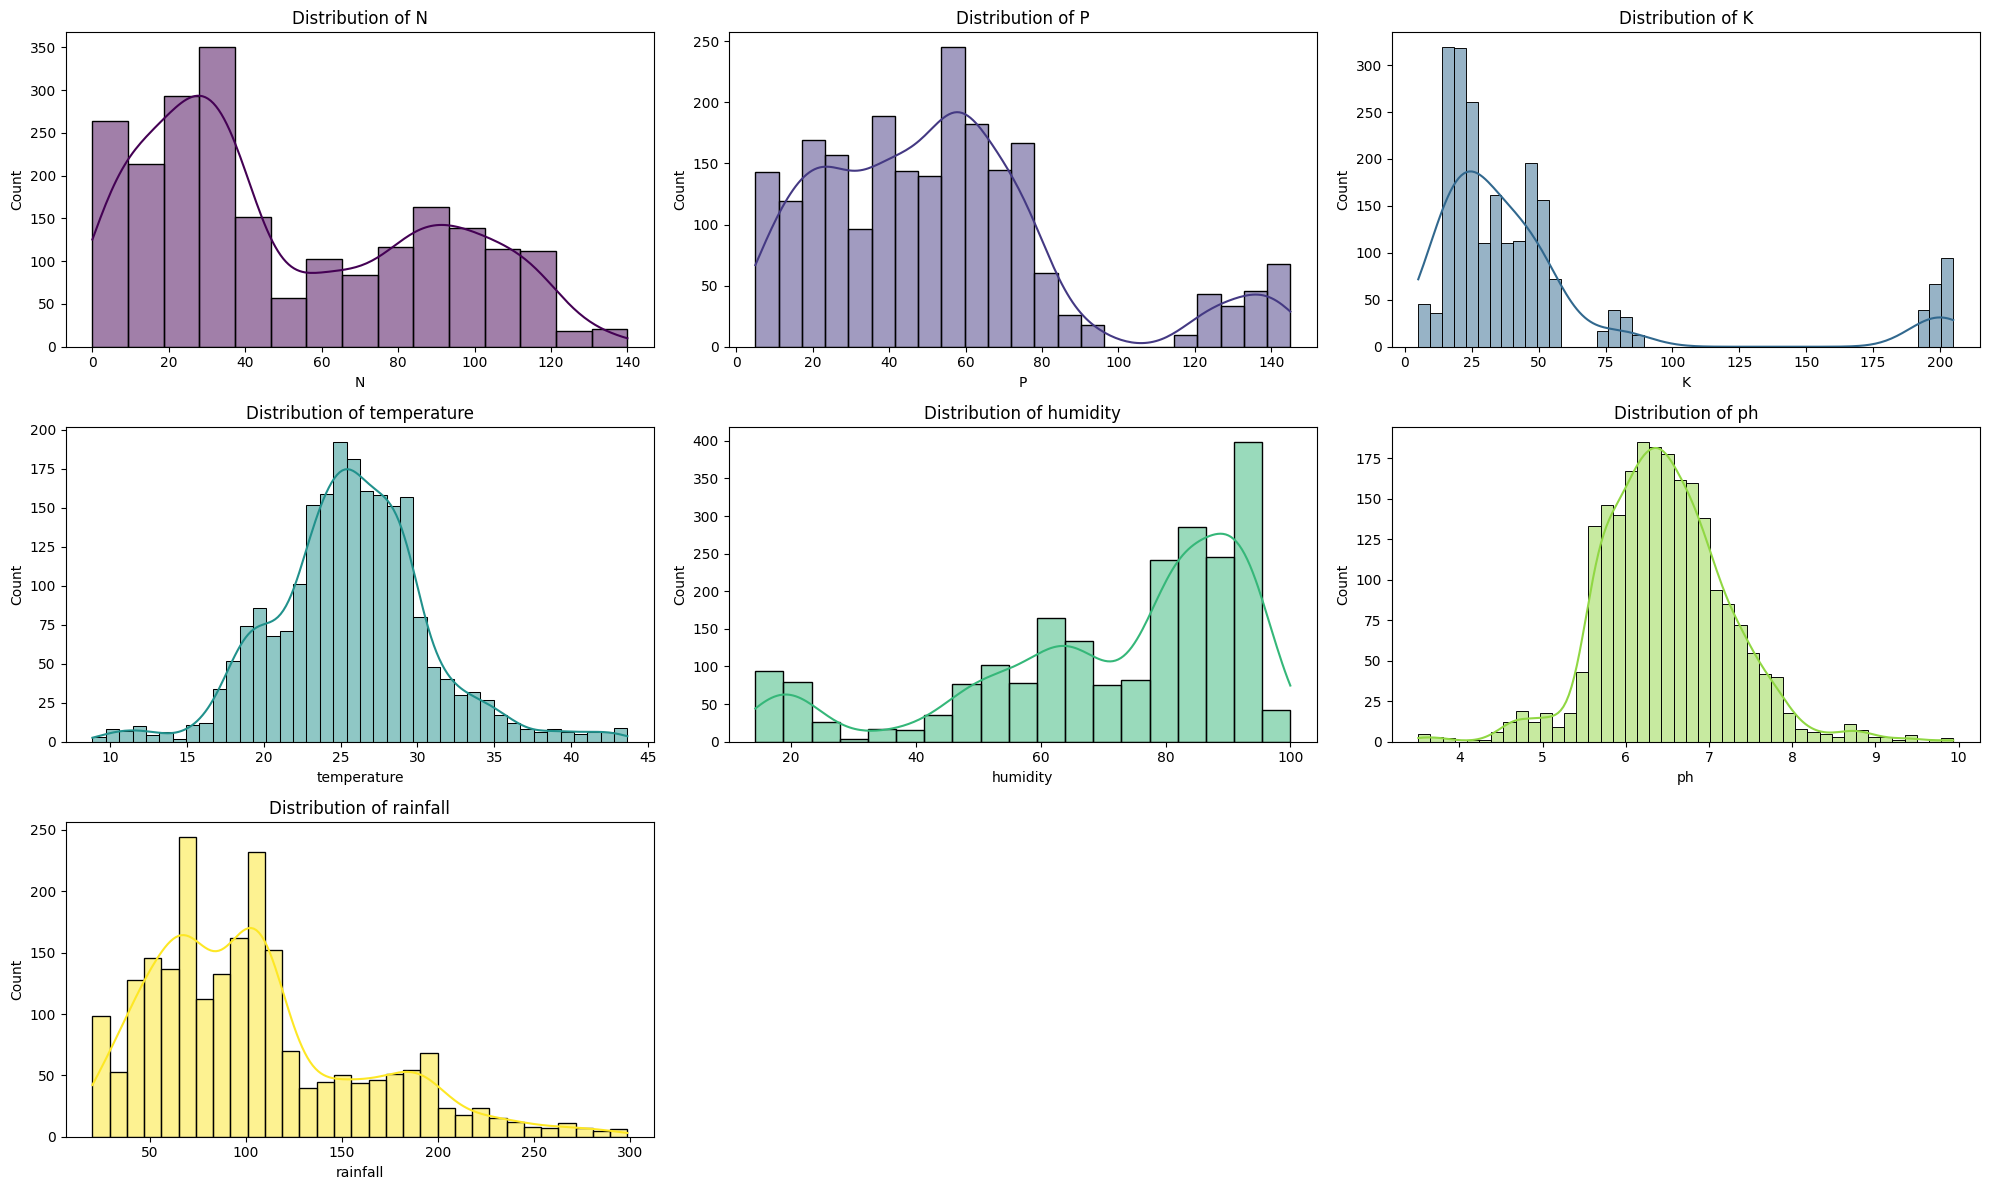

In [8]:
plt.figure(figsize=(20, 12))
colors = plt.cm.viridis(np.linspace(0, 1, 7))

for i, (column, color) in enumerate(zip(['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall'], colors)):
    plt.subplot(3, 3, i+1)
    sns.histplot(data=df, x=column, kde=True, color=color)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Count')
plt.tight_layout()
plt.show()


# Box Plot of Features

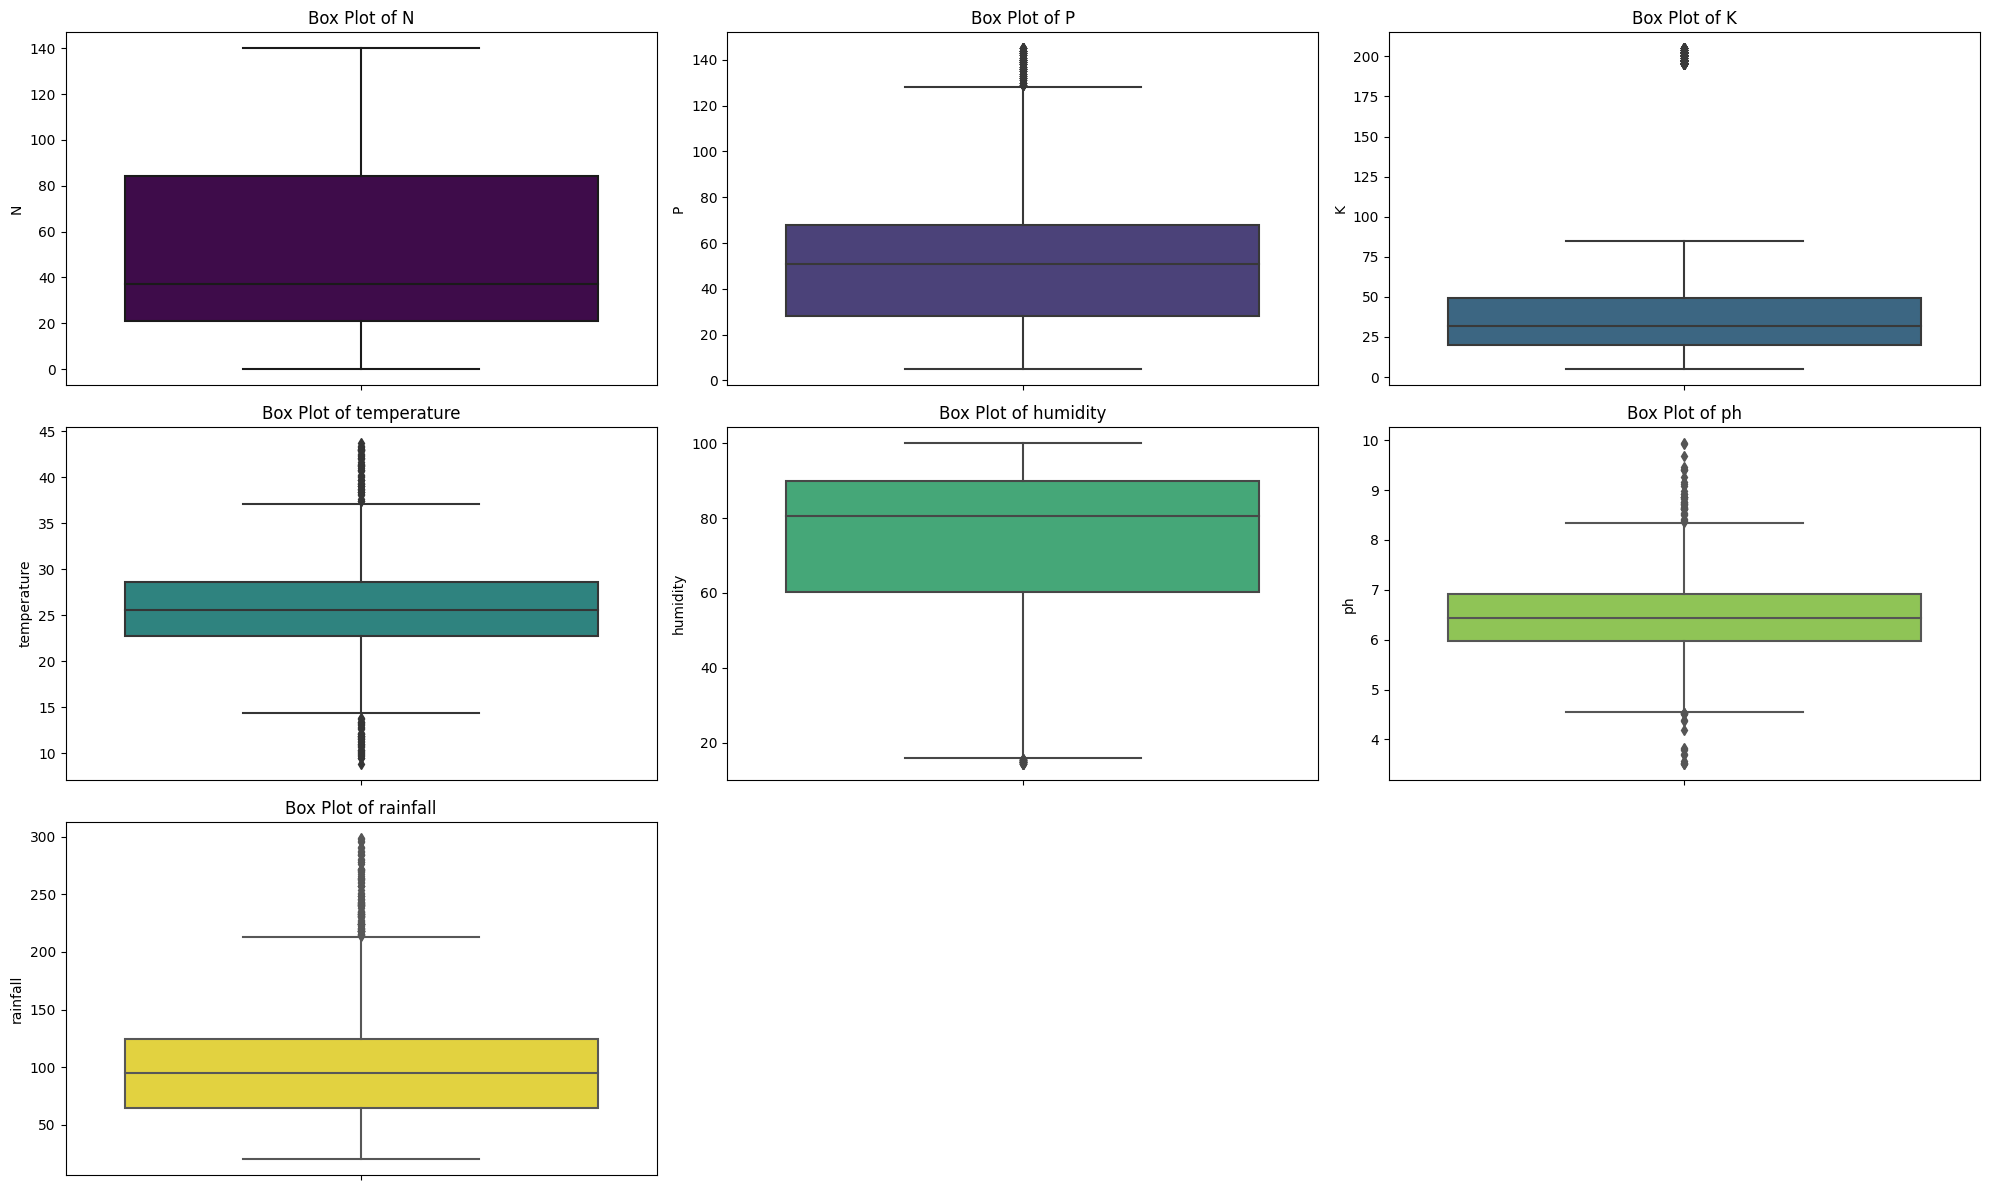

In [9]:
plt.figure(figsize=(20, 12))
for i, (column, color) in enumerate(zip(['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall'], colors)):
    plt.subplot(3, 3, i+1)
    sns.boxplot(data=df, y=column, color=color)
    plt.title(f'Box Plot of {column}')
plt.tight_layout()
plt.show()

# Distribution of Features by Crop


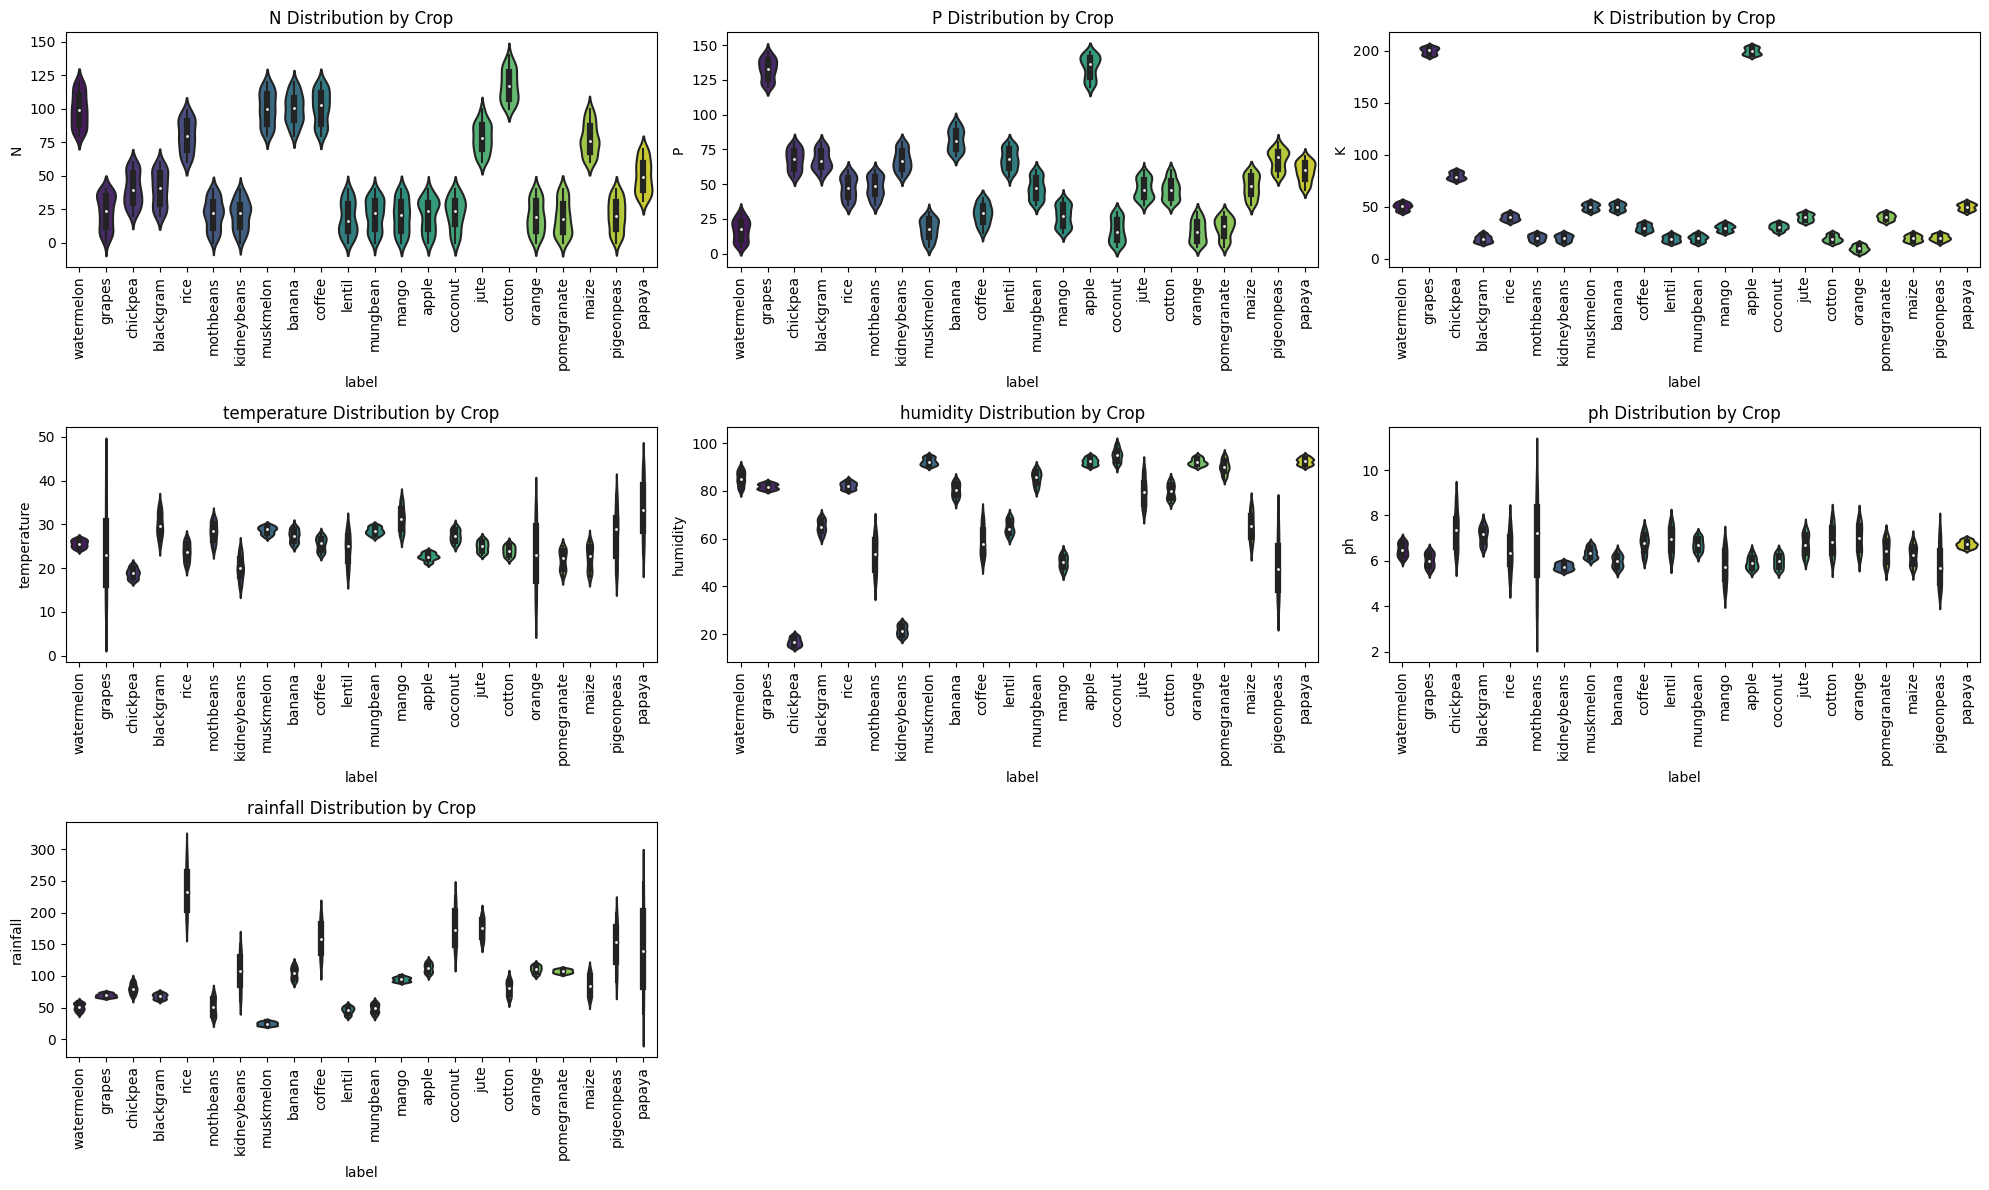

In [10]:
plt.figure(figsize=(20, 12))
for i, column in enumerate(['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall']):
    plt.subplot(3, 3, i+1)
    sns.violinplot(data=df, x='label', y=column, palette='viridis')
    plt.xticks(rotation=90)
    plt.title(f'{column} Distribution by Crop')
plt.tight_layout()
plt.show()

# Correlation Heatmap


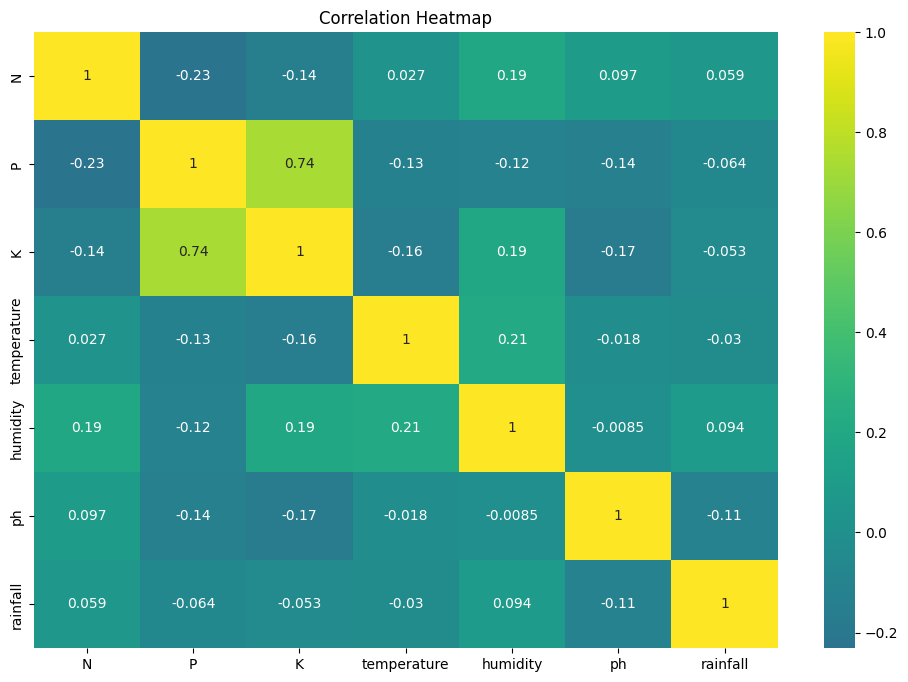

In [11]:
plt.figure(figsize=(12, 8))
correlation_matrix = df.drop('label', axis=1).corr()
sns.heatmap(correlation_matrix, annot=True, cmap='viridis', center=0)
plt.title('Correlation Heatmap')
plt.show()

# Distribution of Crops


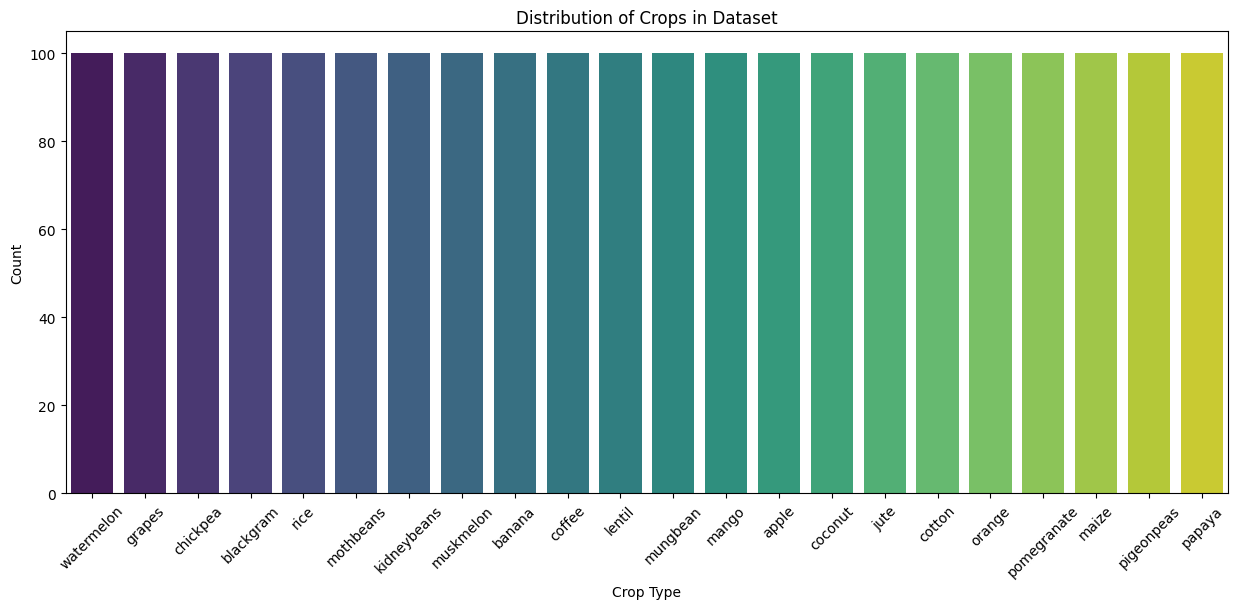

In [12]:
plt.figure(figsize=(15, 6))
sns.countplot(data=df, x='label', palette='viridis')
plt.xticks(rotation=45)
plt.title('Distribution of Crops in Dataset')
plt.xlabel('Crop Type')
plt.ylabel('Count')
plt.show()


# Pair Plot of Numerical Features

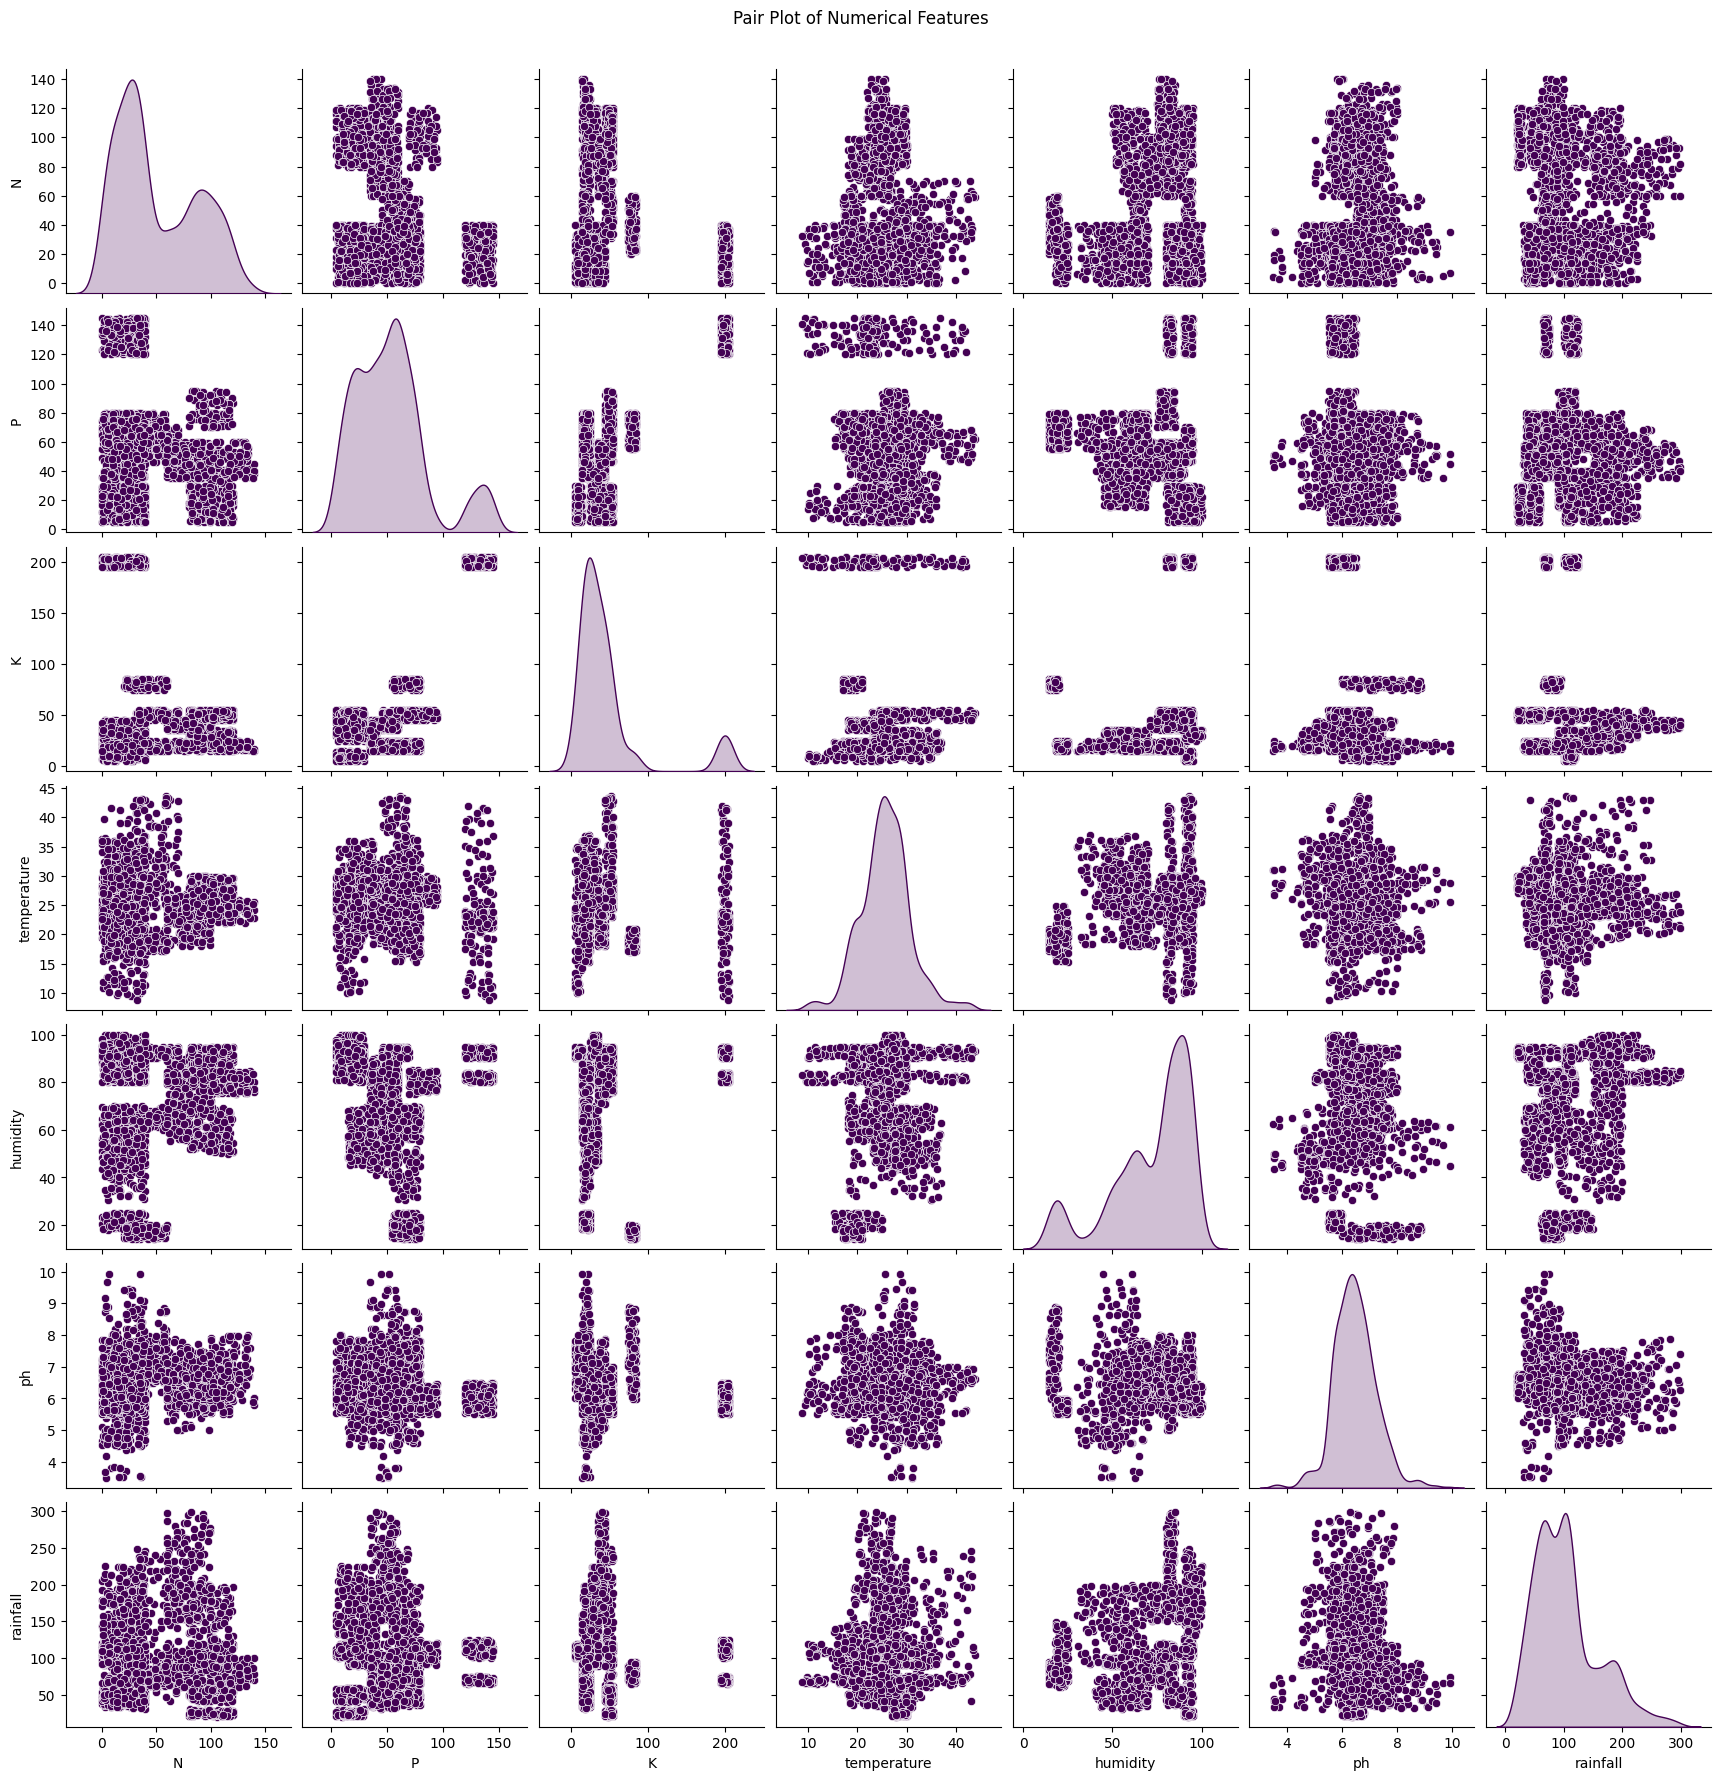

In [13]:
sns.pairplot(df.drop('label', axis=1), diag_kind='kde', palette='viridis')
plt.suptitle('Pair Plot of Numerical Features', y=1.02)
plt.show()

# Scatter Plots of Feature Relationships

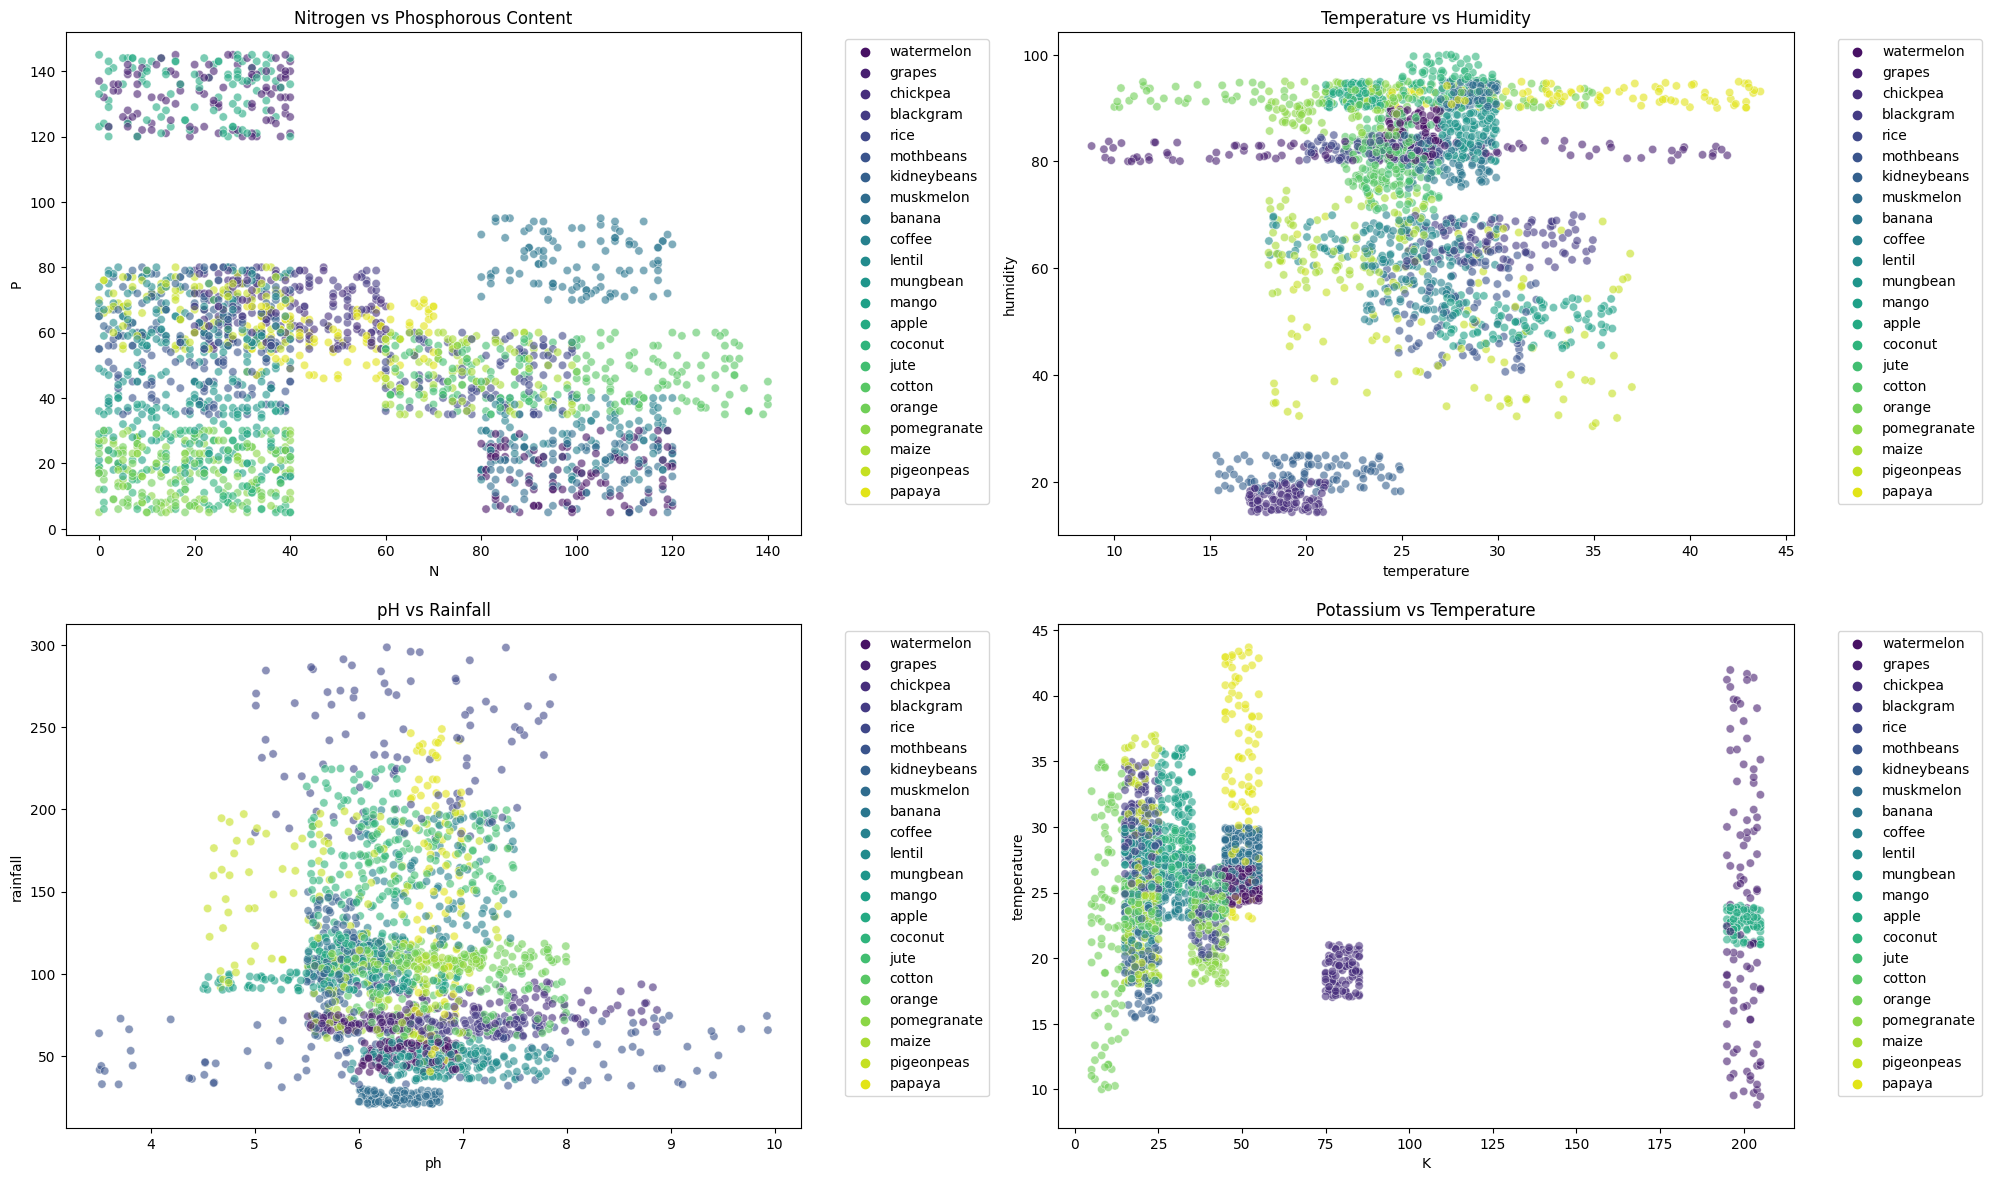

In [14]:

plt.figure(figsize=(20, 12))

# N vs P
plt.subplot(2, 2, 1)
sns.scatterplot(data=df, x='N', y='P', hue='label', palette='viridis', alpha=0.6)
plt.title('Nitrogen vs Phosphorous Content')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Temperature vs Humidity
plt.subplot(2, 2, 2)
sns.scatterplot(data=df, x='temperature', y='humidity', hue='label', palette='viridis', alpha=0.6)
plt.title('Temperature vs Humidity')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# pH vs Rainfall
plt.subplot(2, 2, 3)
sns.scatterplot(data=df, x='ph', y='rainfall', hue='label', palette='viridis', alpha=0.6)
plt.title('pH vs Rainfall')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# K vs Temperature
plt.subplot(2, 2, 4)
sns.scatterplot(data=df, x='K', y='temperature', hue='label', palette='viridis', alpha=0.6)
plt.title('Potassium vs Temperature')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


# Skewness Analysis


In [15]:

print("Skewness Analysis:")
print("=================")
numerical_features = ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall']
for feature in numerical_features:
    skewness = df[feature].skew()
    print(f"{feature}: {skewness:.3f}")


Skewness Analysis:
N: 0.510
P: 1.011
K: 2.375
temperature: 0.185
humidity: -1.092
ph: 0.284
rainfall: 0.966


# Feature Ranges and Statistical Analysis by Crop


In [16]:

def print_feature_ranges(df, numerical_features):
    """
    Print beautifully formatted feature ranges with dark mode optimized colors.

    Parameters:
    df (pandas.DataFrame): Input dataframe with crop data
    numerical_features (list): List of numerical feature names
    """
    # Custom theme for dark mode
    custom_theme = Theme({
        "info": "bright_yellow",
        "title": "bright_white on blue",
        "crop": "bright_green",
        "feature": "bright_cyan",
        "header": "bright_magenta",
        "border": "bright_blue",
        "stats": "bright_yellow",
        "highlight": "bright_white",
        "value": "bright_green"
    })

    console = Console(theme=custom_theme)
    data_rows = []

    # Create title
    title = Text("🌾 FEATURE RANGES BY CROP 🌾", style="title")
    title_panel = Panel(
        title,
        box=box.DOUBLE,
        padding=(1, 30),
        style="border",
        title="Analysis Report"
    )
    console.print("\n")
    console.print(title_panel)
    console.print("\n")

    # Process each crop
    for crop in sorted(df['label'].unique()):
        crop_data = df[df['label'] == crop]

        # Create crop header
        crop_title = Text(f"\n📊 Crop: {crop.upper()}", style="crop")
        console.print(crop_title)

        # Create table for this crop
        table = Table(
            show_header=True,
            header_style="header",
            box=box.ROUNDED,
            border_style="border",
            show_lines=True,
            title=f"Statistics for {crop.upper()}",
            title_style="highlight"
        )

        # Add columns
        table.add_column("Feature", style="feature", justify="left")
        table.add_column("Minimum", style="value", justify="right")
        table.add_column("Maximum", style="value", justify="right")
        table.add_column("Range", style="value", justify="right")
        table.add_column("Mean", style="value", justify="right")

        # Process features for this crop
        for feature in numerical_features:
            min_val = crop_data[feature].min()
            max_val = crop_data[feature].max()
            mean_val = crop_data[feature].mean()
            range_val = max_val - min_val

            # Add row to table
            table.add_row(
                feature,
                f"{min_val:,.2f}",
                f"{max_val:,.2f}",
                f"{range_val:,.2f}",
                f"{mean_val:,.2f}"
            )

            # Store data for DataFrame
            data_rows.append({
                'Crop': crop,
                'Feature': feature,
                'Min': min_val,
                'Max': max_val,
                'Range': range_val,
                'Mean': mean_val
            })

        # Print table with border
        console.print(Panel(table, border_style="border"))

        # Print summary statistics for this crop
        summary_text = Text("\n📈 Key Statistics:", style="stats")
        console.print(summary_text)

        # Find feature with highest range
        max_range_feature = max(numerical_features, key=lambda x: crop_data[x].max() - crop_data[x].min())
        max_range_value = crop_data[max_range_feature].max() - crop_data[max_range_feature].min()

        # Find feature with highest variability (coefficient of variation)
        cv_values = {feature: crop_data[feature].std() / crop_data[feature].mean() * 100
                    for feature in numerical_features}
        most_variable_feature = max(cv_values, key=cv_values.get)

        # Print statistics with improved formatting
        console.print(Panel(
            "\n".join([
                f"[highlight]•[/highlight] Most variable feature: [feature]{max_range_feature}[/feature] (Range: [value]{max_range_value:,.2f}[/value])",
                f"[highlight]•[/highlight] Highest CV: [feature]{most_variable_feature}[/feature] (CV: [value]{cv_values[most_variable_feature]:.2f}%[/value])",
                f"[highlight]•[/highlight] Average {max_range_feature}: [value]{crop_data[max_range_feature].mean():,.2f}[/value]"
            ]),
            title="Summary",
            border_style="border",
            box=box.ROUNDED
        ))

        console.print("\n" + "─" * 80 + "\n")

    return pd.DataFrame(data_rows)

# Execute the function
feature_ranges_df = print_feature_ranges(df, numerical_features)

╔════════════════════════════════════════════════ Analysis Report ════════════════════════════════════════════════╗
║                                                                                                                 ║
║                              🌾 FEATURE RANGES BY CROP 🌾                                                       ║
║                                                                                                                 ║
╚═════════════════════════════════════════════════════════════════════════════════════════════════════════════════╝

📊 Crop: APPLE

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│                 Statistics for APPLE                                                                            │
│ ╭─────────────┬─────────┬─────────┬───────┬────────╮                                                            │
│ │ Feature     │ Minimum │ Maximum │ Range │   Mean │                                                            │
│ ├─────────────┼─────────┼─────────┼───────┼────────┤                                                            │
│ │ N           │    0.00 │   40.00 │ 40.00 │  20.80 │                                                            │
│ ├─────────────┼─────────┼─────────┼───────┼────────┤                                                            │
│ │ P           │  120.00 │  145.00 │ 25.00 │ 134.22 │                                                            │
│ ├─────────────┼─────────┼─────────┼───────┼────────┤                                                            │
│ │ K           │  195.00 │  205.00 │ 10.00 │ 199.89 │                                                            │
│ ├─────────────┼─────────┼─────────┼───────┼────────┤                                                            │
│ │ temperature │   21.04 │   24.00 │  2.96 │  22.63 │                                                            │
│ ├─────────────┼─────────┼─────────┼───────┼────────┤                                                            │
│ │ humidity    │   90.03 │   94.92 │  4.89 │  92.33 │                                                            │
│ ├─────────────┼─────────┼─────────┼───────┼────────┤                                                            │
│ │ ph          │    5.51 │    6.50 │  0.98 │   5.93 │                                                            │
│ ├─────────────┼─────────┼─────────┼───────┼────────┤                                                            │
│ │ rainfall    │  100.12 │  124.98 │ 24.87 │ 112.65 │                                                            │
│ ╰─────────────┴─────────┴─────────┴───────┴────────╯                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

📈 Key Statistics:

╭──────────────────────────────────────────────────── Summary ────────────────────────────────────────────────────╮
│ • Most variable feature: N (Range: 40.00)                                                                       │
│ • Highest CV: N (CV: 57.04%)                                                                                    │
│ • Average N: 20.80                                                                                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

────────────────────────────────────────────────────────────────────────────────

📊 Crop: BANANA

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│                Statistics for BANANA                                                                            │
│ ╭─────────────┬─────────┬─────────┬───────┬────────╮                                                            │
│ │ Feature     │ Minimum │ Maximum │ Range │   Mean │                                                            │
│ ├─────────────┼─────────┼─────────┼───────┼────────┤                                                            │
│ │ N           │   80.00 │  120.00 │ 40.00 │ 100.23 │                                                            │
│ ├─────────────┼─────────┼─────────┼───────┼────────┤                                                            │
│ │ P           │   70.00 │   95.00 │ 25.00 │  82.01 │                                                            │
│ ├─────────────┼─────────┼─────────┼───────┼────────┤                                                            │
│ │ K           │   45.00 │   55.00 │ 10.00 │  50.05 │                                                            │
│ ├─────────────┼─────────┼─────────┼───────┼────────┤                                                            │
│ │ temperature │   25.01 │   29.91 │  4.90 │  27.38 │                                                            │
│ ├─────────────┼─────────┼─────────┼───────┼────────┤                                                            │
│ │ humidity    │   75.03 │   84.98 │  9.95 │  80.36 │                                                            │
│ ├─────────────┼─────────┼─────────┼───────┼────────┤                                                            │
│ │ ph          │    5.51 │    6.49 │  0.98 │   5.98 │                                                            │
│ ├─────────────┼─────────┼─────────┼───────┼────────┤                                                            │
│ │ rainfall    │   90.11 │  119.85 │ 29.74 │ 104.63 │                                                            │
│ ╰─────────────┴─────────┴─────────┴───────┴────────╯                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

📈 Key Statistics:

╭──────────────────────────────────────────────────── Summary ────────────────────────────────────────────────────╮
│ • Most variable feature: N (Range: 40.00)                                                                       │
│ • Highest CV: N (CV: 11.08%)                                                                                    │
│ • Average N: 100.23                                                                                             │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

────────────────────────────────────────────────────────────────────────────────

📊 Crop: BLACKGRAM

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│              Statistics for BLACKGRAM                                                                           │
│ ╭─────────────┬─────────┬─────────┬───────┬───────╮                                                             │
│ │ Feature     │ Minimum │ Maximum │ Range │  Mean │                                                             │
│ ├─────────────┼─────────┼─────────┼───────┼───────┤                                                             │
│ │ N           │   20.00 │   60.00 │ 40.00 │ 40.02 │                                                             │
│ ├─────────────┼─────────┼─────────┼───────┼───────┤                                                             │
│ │ P           │   55.00 │   80.00 │ 25.00 │ 67.47 │                                                             │
│ ├─────────────┼─────────┼─────────┼───────┼───────┤                                                             │
│ │ K           │   15.00 │   25.00 │ 10.00 │ 19.24 │                                                             │
│ ├─────────────┼─────────┼─────────┼───────┼───────┤                                                             │
│ │ temperature │   25.10 │   34.95 │  9.85 │ 29.97 │                                                             │
│ ├─────────────┼─────────┼─────────┼───────┼───────┤                                                             │
│ │ humidity    │   60.07 │   69.96 │  9.90 │ 65.12 │                                                             │
│ ├─────────────┼─────────┼─────────┼───────┼───────┤                                                             │
│ │ ph          │    6.50 │    7.78 │  1.28 │  7.13 │                                                             │
│ ├─────────────┼─────────┼─────────┼───────┼───────┤                                                             │
│ │ rainfall    │   60.42 │   74.92 │ 14.50 │ 67.88 │                                                             │
│ ╰─────────────┴─────────┴─────────┴───────┴───────╯                                                             │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

📈 Key Statistics:

╭──────────────────────────────────────────────────── Summary ────────────────────────────────────────────────────╮
│ • Most variable feature: N (Range: 40.00)                                                                       │
│ • Highest CV: N (CV: 31.64%)                                                                                    │
│ • Average N: 40.02                                                                                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

────────────────────────────────────────────────────────────────────────────────

📊 Crop: CHICKPEA

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│               Statistics for CHICKPEA                                                                           │
│ ╭─────────────┬─────────┬─────────┬───────┬───────╮                                                             │
│ │ Feature     │ Minimum │ Maximum │ Range │  Mean │                                                             │
│ ├─────────────┼─────────┼─────────┼───────┼───────┤                                                             │
│ │ N           │   20.00 │   60.00 │ 40.00 │ 40.09 │                                                             │
│ ├─────────────┼─────────┼─────────┼───────┼───────┤                                                             │
│ │ P           │   55.00 │   80.00 │ 25.00 │ 67.79 │                                                             │
│ ├─────────────┼─────────┼─────────┼───────┼───────┤                                                             │
│ │ K           │   75.00 │   85.00 │ 10.00 │ 79.92 │                                                             │
│ ├─────────────┼─────────┼─────────┼───────┼───────┤                                                             │
│ │ temperature │   17.02 │   21.00 │  3.97 │ 18.87 │                                                             │
│ ├─────────────┼─────────┼─────────┼───────┼───────┤                                                             │
│ │ humidity    │   14.26 │   19.97 │  5.71 │ 16.86 │                                                             │
│ ├─────────────┼─────────┼─────────┼───────┼───────┤                                                             │
│ │ ph          │    5.99 │    8.87 │  2.88 │  7.34 │                                                             │
│ ├─────────────┼─────────┼─────────┼───────┼───────┤                                                             │
│ │ rainfall    │   65.11 │   94.78 │ 29.67 │ 80.06 │                                                             │
│ ╰─────────────┴─────────┴─────────┴───────┴───────╯                                                             │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

📈 Key Statistics:

╭──────────────────────────────────────────────────── Summary ────────────────────────────────────────────────────╮
│ • Most variable feature: N (Range: 40.00)                                                                       │
│ • Highest CV: N (CV: 30.31%)                                                                                    │
│ • Average N: 40.09                                                                                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

────────────────────────────────────────────────────────────────────────────────

📊 Crop: COCONUT

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│                Statistics for COCONUT                                                                           │
│ ╭─────────────┬─────────┬─────────┬───────┬────────╮                                                            │
│ │ Feature     │ Minimum │ Maximum │ Range │   Mean │                                                            │
│ ├─────────────┼─────────┼─────────┼───────┼────────┤                                                            │
│ │ N           │    0.00 │   40.00 │ 40.00 │  21.98 │                                                            │
│ ├─────────────┼─────────┼─────────┼───────┼────────┤                                                            │
│ │ P           │    5.00 │   30.00 │ 25.00 │  16.93 │                                                            │
│ ├─────────────┼─────────┼─────────┼───────┼────────┤                                                            │
│ │ K           │   25.00 │   35.00 │ 10.00 │  30.59 │                                                            │
│ ├─────────────┼─────────┼─────────┼───────┼────────┤                                                            │
│ │ temperature │   25.01 │   29.87 │  4.86 │  27.41 │                                                            │
│ ├─────────────┼─────────┼─────────┼───────┼────────┤                                                            │
│ │ humidity    │   90.02 │   99.98 │  9.96 │  94.84 │                                                            │
│ ├─────────────┼─────────┼─────────┼───────┼────────┤                                                            │
│ │ ph          │    5.50 │    6.47 │  0.97 │   5.98 │                                                            │
│ ├─────────────┼─────────┼─────────┼───────┼────────┤                                                            │
│ │ rainfall    │  131.09 │  225.63 │ 94.54 │ 175.69 │                                                            │
│ ╰─────────────┴─────────┴─────────┴───────┴────────╯                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

📈 Key Statistics:

╭──────────────────────────────────────────────────── Summary ────────────────────────────────────────────────────╮
│ • Most variable feature: rainfall (Range: 94.54)                                                                │
│ • Highest CV: N (CV: 53.51%)                                                                                    │
│ • Average rainfall: 175.69                                                                                      │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

────────────────────────────────────────────────────────────────────────────────

📊 Crop: COFFEE

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│                Statistics for COFFEE                                                                            │
│ ╭─────────────┬─────────┬─────────┬───────┬────────╮                                                            │
│ │ Feature     │ Minimum │ Maximum │ Range │   Mean │                                                            │
│ ├─────────────┼─────────┼─────────┼───────┼────────┤                                                            │
│ │ N           │   80.00 │  120.00 │ 40.00 │ 101.20 │                                                            │
│ ├─────────────┼─────────┼─────────┼───────┼────────┤                                                            │
│ │ P           │   15.00 │   40.00 │ 25.00 │  28.74 │                                                            │
│ ├─────────────┼─────────┼─────────┼───────┼────────┤                                                            │
│ │ K           │   25.00 │   35.00 │ 10.00 │  29.94 │                                                            │
│ ├─────────────┼─────────┼─────────┼───────┼────────┤                                                            │
│ │ temperature │   23.06 │   27.92 │  4.86 │  25.54 │                                                            │
│ ├─────────────┼─────────┼─────────┼───────┼────────┤                                                            │
│ │ humidity    │   50.05 │   69.95 │ 19.90 │  58.87 │                                                            │
│ ├─────────────┼─────────┼─────────┼───────┼────────┤                                                            │
│ │ ph          │    6.02 │    7.49 │  1.47 │   6.79 │                                                            │
│ ├─────────────┼─────────┼─────────┼───────┼────────┤                                                            │
│ │ rainfall    │  115.16 │  199.47 │ 84.32 │ 158.07 │                                                            │
│ ╰─────────────┴─────────┴─────────┴───────┴────────╯                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

📈 Key Statistics:

╭──────────────────────────────────────────────────── Summary ────────────────────────────────────────────────────╮
│ • Most variable feature: rainfall (Range: 84.32)                                                                │
│ • Highest CV: P (CV: 25.32%)                                                                                    │
│ • Average rainfall: 158.07                                                                                      │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

────────────────────────────────────────────────────────────────────────────────

📊 Crop: COTTON

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│                Statistics for COTTON                                                                            │
│ ╭─────────────┬─────────┬─────────┬───────┬────────╮                                                            │
│ │ Feature     │ Minimum │ Maximum │ Range │   Mean │                                                            │
│ ├─────────────┼─────────┼─────────┼───────┼────────┤                                                            │
│ │ N           │  100.00 │  140.00 │ 40.00 │ 117.77 │                                                            │
│ ├─────────────┼─────────┼─────────┼───────┼────────┤                                                            │
│ │ P           │   35.00 │   60.00 │ 25.00 │  46.24 │                                                            │
│ ├─────────────┼─────────┼─────────┼───────┼────────┤                                                            │
│ │ K           │   15.00 │   25.00 │ 10.00 │  19.56 │                                                            │
│ ├─────────────┼─────────┼─────────┼───────┼────────┤                                                            │
│ │ temperature │   22.00 │   25.99 │  3.99 │  23.99 │                                                            │
│ ├─────────────┼─────────┼─────────┼───────┼────────┤                                                            │
│ │ humidity    │   75.01 │   84.88 │  9.87 │  79.84 │                                                            │
│ ├─────────────┼─────────┼─────────┼───────┼────────┤                                                            │
│ │ ph          │    5.80 │    7.99 │  2.19 │   6.91 │                                                            │
│ ├─────────────┼─────────┼─────────┼───────┼────────┤                                                            │
│ │ rainfall    │   60.65 │   99.93 │ 39.28 │  80.40 │                                                            │
│ ╰─────────────┴─────────┴─────────┴───────┴────────╯                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

📈 Key Statistics:

╭──────────────────────────────────────────────────── Summary ────────────────────────────────────────────────────╮
│ • Most variable feature: N (Range: 40.00)                                                                       │
│ • Highest CV: K (CV: 16.20%)                                                                                    │
│ • Average N: 117.77                                                                                             │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

────────────────────────────────────────────────────────────────────────────────

📊 Crop: GRAPES

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│                Statistics for GRAPES                                                                            │
│ ╭─────────────┬─────────┬─────────┬───────┬────────╮                                                            │
│ │ Feature     │ Minimum │ Maximum │ Range │   Mean │                                                            │
│ ├─────────────┼─────────┼─────────┼───────┼────────┤                                                            │
│ │ N           │    0.00 │   40.00 │ 40.00 │  23.18 │                                                            │
│ ├─────────────┼─────────┼─────────┼───────┼────────┤                                                            │
│ │ P           │  120.00 │  145.00 │ 25.00 │ 132.53 │                                                            │
│ ├─────────────┼─────────┼─────────┼───────┼────────┤                                                            │
│ │ K           │  195.00 │  205.00 │ 10.00 │ 200.11 │                                                            │
│ ├─────────────┼─────────┼─────────┼───────┼────────┤                                                            │
│ │ temperature │    8.83 │   41.95 │ 33.12 │  23.85 │                                                            │
│ ├─────────────┼─────────┼─────────┼───────┼────────┤                                                            │
│ │ humidity    │   80.02 │   83.98 │  3.97 │  81.88 │                                                            │
│ ├─────────────┼─────────┼─────────┼───────┼────────┤                                                            │
│ │ ph          │    5.51 │    6.50 │  0.99 │   6.03 │                                                            │
│ ├─────────────┼─────────┼─────────┼───────┼────────┤                                                            │
│ │ rainfall    │   65.01 │   74.92 │  9.90 │  69.61 │                                                            │
│ ╰─────────────┴─────────┴─────────┴───────┴────────╯                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

📈 Key Statistics:

╭──────────────────────────────────────────────────── Summary ────────────────────────────────────────────────────╮
│ • Most variable feature: N (Range: 40.00)                                                                       │
│ • Highest CV: N (CV: 53.78%)                                                                                    │
│ • Average N: 23.18                                                                                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

────────────────────────────────────────────────────────────────────────────────

📊 Crop: JUTE

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│                 Statistics for JUTE                                                                             │
│ ╭─────────────┬─────────┬─────────┬───────┬────────╮                                                            │
│ │ Feature     │ Minimum │ Maximum │ Range │   Mean │                                                            │
│ ├─────────────┼─────────┼─────────┼───────┼────────┤                                                            │
│ │ N           │   60.00 │  100.00 │ 40.00 │  78.40 │                                                            │
│ ├─────────────┼─────────┼─────────┼───────┼────────┤                                                            │
│ │ P           │   35.00 │   60.00 │ 25.00 │  46.86 │                                                            │
│ ├─────────────┼─────────┼─────────┼───────┼────────┤                                                            │
│ │ K           │   35.00 │   45.00 │ 10.00 │  39.99 │                                                            │
│ ├─────────────┼─────────┼─────────┼───────┼────────┤                                                            │
│ │ temperature │   23.09 │   26.99 │  3.89 │  24.96 │                                                            │
│ ├─────────────┼─────────┼─────────┼───────┼────────┤                                                            │
│ │ humidity    │   70.88 │   89.89 │ 19.01 │  79.64 │                                                            │
│ ├─────────────┼─────────┼─────────┼───────┼────────┤                                                            │
│ │ ph          │    6.00 │    7.49 │  1.49 │   6.73 │                                                            │
│ ├─────────────┼─────────┼─────────┼───────┼────────┤                                                            │
│ │ rainfall    │  150.24 │  199.84 │ 49.60 │ 174.79 │                                                            │
│ ╰─────────────┴─────────┴─────────┴───────┴────────╯                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

📈 Key Statistics:

╭──────────────────────────────────────────────────── Summary ────────────────────────────────────────────────────╮
│ • Most variable feature: rainfall (Range: 49.60)                                                                │
│ • Highest CV: P (CV: 15.36%)                                                                                    │
│ • Average rainfall: 174.79                                                                                      │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

────────────────────────────────────────────────────────────────────────────────

📊 Crop: KIDNEYBEANS

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│              Statistics for KIDNEYBEANS                                                                         │
│ ╭─────────────┬─────────┬─────────┬───────┬────────╮                                                            │
│ │ Feature     │ Minimum │ Maximum │ Range │   Mean │                                                            │
│ ├─────────────┼─────────┼─────────┼───────┼────────┤                                                            │
│ │ N           │    0.00 │   40.00 │ 40.00 │  20.75 │                                                            │
│ ├─────────────┼─────────┼─────────┼───────┼────────┤                                                            │
│ │ P           │   55.00 │   80.00 │ 25.00 │  67.54 │                                                            │
│ ├─────────────┼─────────┼─────────┼───────┼────────┤                                                            │
│ │ K           │   15.00 │   25.00 │ 10.00 │  20.05 │                                                            │
│ ├─────────────┼─────────┼─────────┼───────┼────────┤                                                            │
│ │ temperature │   15.33 │   24.92 │  9.59 │  20.12 │                                                            │
│ ├─────────────┼─────────┼─────────┼───────┼────────┤                                                            │
│ │ humidity    │   18.09 │   24.97 │  6.88 │  21.61 │                                                            │
│ ├─────────────┼─────────┼─────────┼───────┼────────┤                                                            │
│ │ ph          │    5.50 │    6.00 │  0.50 │   5.75 │                                                            │
│ ├─────────────┼─────────┼─────────┼───────┼────────┤                                                            │
│ │ rainfall    │   60.28 │  149.74 │ 89.47 │ 105.92 │                                                            │
│ ╰─────────────┴─────────┴─────────┴───────┴────────╯                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

📈 Key Statistics:

╭──────────────────────────────────────────────────── Summary ────────────────────────────────────────────────────╮
│ • Most variable feature: rainfall (Range: 89.47)                                                                │
│ • Highest CV: N (CV: 52.21%)                                                                                    │
│ • Average rainfall: 105.92                                                                                      │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

────────────────────────────────────────────────────────────────────────────────

📊 Crop: LENTIL

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│                Statistics for LENTIL                                                                            │
│ ╭─────────────┬─────────┬─────────┬───────┬───────╮                                                             │
│ │ Feature     │ Minimum │ Maximum │ Range │  Mean │                                                             │
│ ├─────────────┼─────────┼─────────┼───────┼───────┤                                                             │
│ │ N           │    0.00 │   40.00 │ 40.00 │ 18.77 │                                                             │
│ ├─────────────┼─────────┼─────────┼───────┼───────┤                                                             │
│ │ P           │   55.00 │   80.00 │ 25.00 │ 68.36 │                                                             │
│ ├─────────────┼─────────┼─────────┼───────┼───────┤                                                             │
│ │ K           │   15.00 │   25.00 │ 10.00 │ 19.41 │                                                             │
│ ├─────────────┼─────────┼─────────┼───────┼───────┤                                                             │
│ │ temperature │   18.06 │   29.94 │ 11.88 │ 24.51 │                                                             │
│ ├─────────────┼─────────┼─────────┼───────┼───────┤                                                             │
│ │ humidity    │   60.09 │   69.92 │  9.83 │ 64.80 │                                                             │
│ ├─────────────┼─────────┼─────────┼───────┼───────┤                                                             │
│ │ ph          │    5.92 │    7.84 │  1.93 │  6.93 │                                                             │
│ ├─────────────┼─────────┼─────────┼───────┼───────┤                                                             │
│ │ rainfall    │   35.03 │   54.94 │ 19.90 │ 45.68 │                                                             │
│ ╰─────────────┴─────────┴─────────┴───────┴───────╯                                                             │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

📈 Key Statistics:

╭──────────────────────────────────────────────────── Summary ────────────────────────────────────────────────────╮
│ • Most variable feature: N (Range: 40.00)                                                                       │
│ • Highest CV: N (CV: 64.98%)                                                                                    │
│ • Average N: 18.77                                                                                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

────────────────────────────────────────────────────────────────────────────────

📊 Crop: MAIZE

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│                Statistics for MAIZE                                                                             │
│ ╭─────────────┬─────────┬─────────┬───────┬───────╮                                                             │
│ │ Feature     │ Minimum │ Maximum │ Range │  Mean │                                                             │
│ ├─────────────┼─────────┼─────────┼───────┼───────┤                                                             │
│ │ N           │   60.00 │  100.00 │ 40.00 │ 77.76 │                                                             │
│ ├─────────────┼─────────┼─────────┼───────┼───────┤                                                             │
│ │ P           │   35.00 │   60.00 │ 25.00 │ 48.44 │                                                             │
│ ├─────────────┼─────────┼─────────┼───────┼───────┤                                                             │
│ │ K           │   15.00 │   25.00 │ 10.00 │ 19.79 │                                                             │
│ ├─────────────┼─────────┼─────────┼───────┼───────┤                                                             │
│ │ temperature │   18.04 │   26.55 │  8.51 │ 22.39 │                                                             │
│ ├─────────────┼─────────┼─────────┼───────┼───────┤                                                             │
│ │ humidity    │   55.28 │   74.83 │ 19.55 │ 65.09 │                                                             │
│ ├─────────────┼─────────┼─────────┼───────┼───────┤                                                             │
│ │ ph          │    5.51 │    7.00 │  1.48 │  6.25 │                                                             │
│ ├─────────────┼─────────┼─────────┼───────┼───────┤                                                             │
│ │ rainfall    │   60.65 │  109.75 │ 49.10 │ 84.77 │                                                             │
│ ╰─────────────┴─────────┴─────────┴───────┴───────╯                                                             │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

📈 Key Statistics:

╭──────────────────────────────────────────────────── Summary ────────────────────────────────────────────────────╮
│ • Most variable feature: rainfall (Range: 49.10)                                                                │
│ • Highest CV: rainfall (CV: 18.34%)                                                                             │
│ • Average rainfall: 84.77                                                                                       │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

────────────────────────────────────────────────────────────────────────────────

📊 Crop: MANGO

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│                Statistics for MANGO                                                                             │
│ ╭─────────────┬─────────┬─────────┬───────┬───────╮                                                             │
│ │ Feature     │ Minimum │ Maximum │ Range │  Mean │                                                             │
│ ├─────────────┼─────────┼─────────┼───────┼───────┤                                                             │
│ │ N           │    0.00 │   40.00 │ 40.00 │ 20.07 │                                                             │
│ ├─────────────┼─────────┼─────────┼───────┼───────┤                                                             │
│ │ P           │   15.00 │   40.00 │ 25.00 │ 27.18 │                                                             │
│ ├─────────────┼─────────┼─────────┼───────┼───────┤                                                             │
│ │ K           │   25.00 │   35.00 │ 10.00 │ 29.92 │                                                             │
│ ├─────────────┼─────────┼─────────┼───────┼───────┤                                                             │
│ │ temperature │   27.00 │   35.99 │  8.99 │ 31.21 │                                                             │
│ ├─────────────┼─────────┼─────────┼───────┼───────┤                                                             │
│ │ humidity    │   45.02 │   54.96 │  9.94 │ 50.16 │                                                             │
│ ├─────────────┼─────────┼─────────┼───────┼───────┤                                                             │
│ │ ph          │    4.51 │    6.97 │  2.46 │  5.77 │                                                             │
│ ├─────────────┼─────────┼─────────┼───────┼───────┤                                                             │
│ │ rainfall    │   89.29 │  100.81 │ 11.52 │ 94.70 │                                                             │
│ ╰─────────────┴─────────┴─────────┴───────┴───────╯                                                             │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

📈 Key Statistics:

╭──────────────────────────────────────────────────── Summary ────────────────────────────────────────────────────╮
│ • Most variable feature: N (Range: 40.00)                                                                       │
│ • Highest CV: N (CV: 61.43%)                                                                                    │
│ • Average N: 20.07                                                                                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

────────────────────────────────────────────────────────────────────────────────

📊 Crop: MOTHBEANS

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│              Statistics for MOTHBEANS                                                                           │
│ ╭─────────────┬─────────┬─────────┬───────┬───────╮                                                             │
│ │ Feature     │ Minimum │ Maximum │ Range │  Mean │                                                             │
│ ├─────────────┼─────────┼─────────┼───────┼───────┤                                                             │
│ │ N           │    0.00 │   40.00 │ 40.00 │ 21.44 │                                                             │
│ ├─────────────┼─────────┼─────────┼───────┼───────┤                                                             │
│ │ P           │   35.00 │   60.00 │ 25.00 │ 48.01 │                                                             │
│ ├─────────────┼─────────┼─────────┼───────┼───────┤                                                             │
│ │ K           │   15.00 │   25.00 │ 10.00 │ 20.23 │                                                             │
│ ├─────────────┼─────────┼─────────┼───────┼───────┤                                                             │
│ │ temperature │   24.02 │   32.00 │  7.98 │ 28.19 │                                                             │
│ ├─────────────┼─────────┼─────────┼───────┼───────┤                                                             │
│ │ humidity    │   40.01 │   64.96 │ 24.95 │ 53.16 │                                                             │
│ ├─────────────┼─────────┼─────────┼───────┼───────┤                                                             │
│ │ ph          │    3.50 │    9.94 │  6.43 │  6.83 │                                                             │
│ ├─────────────┼─────────┼─────────┼───────┼───────┤                                                             │
│ │ rainfall    │   30.92 │   74.44 │ 43.52 │ 51.20 │                                                             │
│ ╰─────────────┴─────────┴─────────┴───────┴───────╯                                                             │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

📈 Key Statistics:

╭──────────────────────────────────────────────────── Summary ────────────────────────────────────────────────────╮
│ • Most variable feature: rainfall (Range: 43.52)                                                                │
│ • Highest CV: N (CV: 52.91%)                                                                                    │
│ • Average rainfall: 51.20                                                                                       │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

────────────────────────────────────────────────────────────────────────────────

📊 Crop: MUNGBEAN

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│               Statistics for MUNGBEAN                                                                           │
│ ╭─────────────┬─────────┬─────────┬───────┬───────╮                                                             │
│ │ Feature     │ Minimum │ Maximum │ Range │  Mean │                                                             │
│ ├─────────────┼─────────┼─────────┼───────┼───────┤                                                             │
│ │ N           │    0.00 │   40.00 │ 40.00 │ 20.99 │                                                             │
│ ├─────────────┼─────────┼─────────┼───────┼───────┤                                                             │
│ │ P           │   35.00 │   60.00 │ 25.00 │ 47.28 │                                                             │
│ ├─────────────┼─────────┼─────────┼───────┼───────┤                                                             │
│ │ K           │   15.00 │   25.00 │ 10.00 │ 19.87 │                                                             │
│ ├─────────────┼─────────┼─────────┼───────┼───────┤                                                             │
│ │ temperature │   27.01 │   29.91 │  2.90 │ 28.53 │                                                             │
│ ├─────────────┼─────────┼─────────┼───────┼───────┤                                                             │
│ │ humidity    │   80.03 │   90.00 │  9.96 │ 85.50 │                                                             │
│ ├─────────────┼─────────┼─────────┼───────┼───────┤                                                             │
│ │ ph          │    6.22 │    7.20 │  0.98 │  6.72 │                                                             │
│ ├─────────────┼─────────┼─────────┼───────┼───────┤                                                             │
│ │ rainfall    │   36.12 │   59.87 │ 23.75 │ 48.40 │                                                             │
│ ╰─────────────┴─────────┴─────────┴───────┴───────╯                                                             │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

📈 Key Statistics:

╭──────────────────────────────────────────────────── Summary ────────────────────────────────────────────────────╮
│ • Most variable feature: N (Range: 40.00)                                                                       │
│ • Highest CV: N (CV: 54.84%)                                                                                    │
│ • Average N: 20.99                                                                                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

────────────────────────────────────────────────────────────────────────────────

📊 Crop: MUSKMELON

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│               Statistics for MUSKMELON                                                                          │
│ ╭─────────────┬─────────┬─────────┬───────┬────────╮                                                            │
│ │ Feature     │ Minimum │ Maximum │ Range │   Mean │                                                            │
│ ├─────────────┼─────────┼─────────┼───────┼────────┤                                                            │
│ │ N           │   80.00 │  120.00 │ 40.00 │ 100.32 │                                                            │
│ ├─────────────┼─────────┼─────────┼───────┼────────┤                                                            │
│ │ P           │    5.00 │   30.00 │ 25.00 │  17.72 │                                                            │
│ ├─────────────┼─────────┼─────────┼───────┼────────┤                                                            │
│ │ K           │   45.00 │   55.00 │ 10.00 │  50.08 │                                                            │
│ ├─────────────┼─────────┼─────────┼───────┼────────┤                                                            │
│ │ temperature │   27.02 │   29.94 │  2.92 │  28.66 │                                                            │
│ ├─────────────┼─────────┼─────────┼───────┼────────┤                                                            │
│ │ humidity    │   90.02 │   94.96 │  4.95 │  92.34 │                                                            │
│ ├─────────────┼─────────┼─────────┼───────┼────────┤                                                            │
│ │ ph          │    6.00 │    6.78 │  0.78 │   6.36 │                                                            │
│ ├─────────────┼─────────┼─────────┼───────┼────────┤                                                            │
│ │ rainfall    │   20.21 │   29.87 │  9.66 │  24.69 │                                                            │
│ ╰─────────────┴─────────┴─────────┴───────┴────────╯                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

📈 Key Statistics:

╭──────────────────────────────────────────────────── Summary ────────────────────────────────────────────────────╮
│ • Most variable feature: N (Range: 40.00)                                                                       │
│ • Highest CV: P (CV: 40.56%)                                                                                    │
│ • Average N: 100.32                                                                                             │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

────────────────────────────────────────────────────────────────────────────────

📊 Crop: ORANGE

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│                Statistics for ORANGE                                                                            │
│ ╭─────────────┬─────────┬─────────┬───────┬────────╮                                                            │
│ │ Feature     │ Minimum │ Maximum │ Range │   Mean │                                                            │
│ ├─────────────┼─────────┼─────────┼───────┼────────┤                                                            │
│ │ N           │    0.00 │   40.00 │ 40.00 │  19.58 │                                                            │
│ ├─────────────┼─────────┼─────────┼───────┼────────┤                                                            │
│ │ P           │    5.00 │   30.00 │ 25.00 │  16.55 │                                                            │
│ ├─────────────┼─────────┼─────────┼───────┼────────┤                                                            │
│ │ K           │    5.00 │   15.00 │ 10.00 │  10.01 │                                                            │
│ ├─────────────┼─────────┼─────────┼───────┼────────┤                                                            │
│ │ temperature │   10.01 │   34.91 │ 24.90 │  22.77 │                                                            │
│ ├─────────────┼─────────┼─────────┼───────┼────────┤                                                            │
│ │ humidity    │   90.01 │   94.96 │  4.96 │  92.17 │                                                            │
│ ├─────────────┼─────────┼─────────┼───────┼────────┤                                                            │
│ │ ph          │    6.01 │    8.00 │  1.99 │   7.02 │                                                            │
│ ├─────────────┼─────────┼─────────┼───────┼────────┤                                                            │
│ │ rainfall    │  100.17 │  119.69 │ 19.52 │ 110.47 │                                                            │
│ ╰─────────────┴─────────┴─────────┴───────┴────────╯                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

📈 Key Statistics:

╭──────────────────────────────────────────────────── Summary ────────────────────────────────────────────────────╮
│ • Most variable feature: N (Range: 40.00)                                                                       │
│ • Highest CV: N (CV: 60.99%)                                                                                    │
│ • Average N: 19.58                                                                                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

────────────────────────────────────────────────────────────────────────────────

📊 Crop: PAPAYA

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│                 Statistics for PAPAYA                                                                           │
│ ╭─────────────┬─────────┬─────────┬────────┬────────╮                                                           │
│ │ Feature     │ Minimum │ Maximum │  Range │   Mean │                                                           │
│ ├─────────────┼─────────┼─────────┼────────┼────────┤                                                           │
│ │ N           │   31.00 │   70.00 │  39.00 │  49.88 │                                                           │
│ ├─────────────┼─────────┼─────────┼────────┼────────┤                                                           │
│ │ P           │   46.00 │   70.00 │  24.00 │  59.05 │                                                           │
│ ├─────────────┼─────────┼─────────┼────────┼────────┤                                                           │
│ │ K           │   45.00 │   55.00 │  10.00 │  50.04 │                                                           │
│ ├─────────────┼─────────┼─────────┼────────┼────────┤                                                           │
│ │ temperature │   23.01 │   43.68 │  20.66 │  33.72 │                                                           │
│ ├─────────────┼─────────┼─────────┼────────┼────────┤                                                           │
│ │ humidity    │   90.04 │   94.94 │   4.91 │  92.40 │                                                           │
│ ├─────────────┼─────────┼─────────┼────────┼────────┤                                                           │
│ │ ph          │    6.50 │    6.99 │   0.49 │   6.74 │                                                           │
│ ├─────────────┼─────────┼─────────┼────────┼────────┤                                                           │
│ │ rainfall    │   40.35 │  248.86 │ 208.51 │ 142.63 │                                                           │
│ ╰─────────────┴─────────┴─────────┴────────┴────────╯                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

📈 Key Statistics:

╭──────────────────────────────────────────────────── Summary ────────────────────────────────────────────────────╮
│ • Most variable feature: rainfall (Range: 208.51)                                                               │
│ • Highest CV: rainfall (CV: 45.15%)                                                                             │
│ • Average rainfall: 142.63                                                                                      │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

────────────────────────────────────────────────────────────────────────────────

📊 Crop: PIGEONPEAS

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│               Statistics for PIGEONPEAS                                                                         │
│ ╭─────────────┬─────────┬─────────┬────────┬────────╮                                                           │
│ │ Feature     │ Minimum │ Maximum │  Range │   Mean │                                                           │
│ ├─────────────┼─────────┼─────────┼────────┼────────┤                                                           │
│ │ N           │    0.00 │   40.00 │  40.00 │  20.73 │                                                           │
│ ├─────────────┼─────────┼─────────┼────────┼────────┤                                                           │
│ │ P           │   55.00 │   80.00 │  25.00 │  67.73 │                                                           │
│ ├─────────────┼─────────┼─────────┼────────┼────────┤                                                           │
│ │ K           │   15.00 │   25.00 │  10.00 │  20.29 │                                                           │
│ ├─────────────┼─────────┼─────────┼────────┼────────┤                                                           │
│ │ temperature │   18.32 │   36.98 │  18.66 │  27.74 │                                                           │
│ ├─────────────┼─────────┼─────────┼────────┼────────┤                                                           │
│ │ humidity    │   30.40 │   69.69 │  39.29 │  48.06 │                                                           │
│ ├─────────────┼─────────┼─────────┼────────┼────────┤                                                           │
│ │ ph          │    4.55 │    7.45 │   2.90 │   5.79 │                                                           │
│ ├─────────────┼─────────┼─────────┼────────┼────────┤                                                           │
│ │ rainfall    │   90.05 │  198.83 │ 108.78 │ 149.46 │                                                           │
│ ╰─────────────┴─────────┴─────────┴────────┴────────╯                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

📈 Key Statistics:

╭──────────────────────────────────────────────────── Summary ────────────────────────────────────────────────────╮
│ • Most variable feature: rainfall (Range: 108.78)                                                               │
│ • Highest CV: N (CV: 57.16%)                                                                                    │
│ • Average rainfall: 149.46                                                                                      │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

────────────────────────────────────────────────────────────────────────────────

📊 Crop: POMEGRANATE

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│              Statistics for POMEGRANATE                                                                         │
│ ╭─────────────┬─────────┬─────────┬───────┬────────╮                                                            │
│ │ Feature     │ Minimum │ Maximum │ Range │   Mean │                                                            │
│ ├─────────────┼─────────┼─────────┼───────┼────────┤                                                            │
│ │ N           │    0.00 │   40.00 │ 40.00 │  18.87 │                                                            │
│ ├─────────────┼─────────┼─────────┼───────┼────────┤                                                            │
│ │ P           │    5.00 │   30.00 │ 25.00 │  18.75 │                                                            │
│ ├─────────────┼─────────┼─────────┼───────┼────────┤                                                            │
│ │ K           │   35.00 │   45.00 │ 10.00 │  40.21 │                                                            │
│ ├─────────────┼─────────┼─────────┼───────┼────────┤                                                            │
│ │ temperature │   18.07 │   24.96 │  6.89 │  21.84 │                                                            │
│ ├─────────────┼─────────┼─────────┼───────┼────────┤                                                            │
│ │ humidity    │   85.13 │   95.00 │  9.87 │  90.13 │                                                            │
│ ├─────────────┼─────────┼─────────┼───────┼────────┤                                                            │
│ │ ph          │    5.56 │    7.20 │  1.64 │   6.43 │                                                            │
│ ├─────────────┼─────────┼─────────┼───────┼────────┤                                                            │
│ │ rainfall    │  102.52 │  112.48 │  9.96 │ 107.53 │                                                            │
│ ╰─────────────┴─────────┴─────────┴───────┴────────╯                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

📈 Key Statistics:

╭──────────────────────────────────────────────────── Summary ────────────────────────────────────────────────────╮
│ • Most variable feature: N (Range: 40.00)                                                                       │
│ • Highest CV: N (CV: 66.87%)                                                                                    │
│ • Average N: 18.87                                                                                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

────────────────────────────────────────────────────────────────────────────────

📊 Crop: RICE

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│                  Statistics for RICE                                                                            │
│ ╭─────────────┬─────────┬─────────┬────────┬────────╮                                                           │
│ │ Feature     │ Minimum │ Maximum │  Range │   Mean │                                                           │
│ ├─────────────┼─────────┼─────────┼────────┼────────┤                                                           │
│ │ N           │   60.00 │   99.00 │  39.00 │  79.89 │                                                           │
│ ├─────────────┼─────────┼─────────┼────────┼────────┤                                                           │
│ │ P           │   35.00 │   60.00 │  25.00 │  47.58 │                                                           │
│ ├─────────────┼─────────┼─────────┼────────┼────────┤                                                           │
│ │ K           │   35.00 │   45.00 │  10.00 │  39.87 │                                                           │
│ ├─────────────┼─────────┼─────────┼────────┼────────┤                                                           │
│ │ temperature │   20.05 │   26.93 │   6.88 │  23.69 │                                                           │
│ ├─────────────┼─────────┼─────────┼────────┼────────┤                                                           │
│ │ humidity    │   80.12 │   84.97 │   4.85 │  82.27 │                                                           │
│ ├─────────────┼─────────┼─────────┼────────┼────────┤                                                           │
│ │ ph          │    5.01 │    7.87 │   2.86 │   6.43 │                                                           │
│ ├─────────────┼─────────┼─────────┼────────┼────────┤                                                           │
│ │ rainfall    │  182.56 │  298.56 │ 116.00 │ 236.18 │                                                           │
│ ╰─────────────┴─────────┴─────────┴────────┴────────╯                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

📈 Key Statistics:

╭──────────────────────────────────────────────────── Summary ────────────────────────────────────────────────────╮
│ • Most variable feature: rainfall (Range: 116.00)                                                               │
│ • Highest CV: P (CV: 16.61%)                                                                                    │
│ • Average rainfall: 236.18                                                                                      │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

────────────────────────────────────────────────────────────────────────────────

📊 Crop: WATERMELON

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│              Statistics for WATERMELON                                                                          │
│ ╭─────────────┬─────────┬─────────┬───────┬───────╮                                                             │
│ │ Feature     │ Minimum │ Maximum │ Range │  Mean │                                                             │
│ ├─────────────┼─────────┼─────────┼───────┼───────┤                                                             │
│ │ N           │   80.00 │  120.00 │ 40.00 │ 99.42 │                                                             │
│ ├─────────────┼─────────┼─────────┼───────┼───────┤                                                             │
│ │ P           │    5.00 │   30.00 │ 25.00 │ 17.00 │                                                             │
│ ├─────────────┼─────────┼─────────┼───────┼───────┤                                                             │
│ │ K           │   45.00 │   55.00 │ 10.00 │ 50.22 │                                                             │
│ ├─────────────┼─────────┼─────────┼───────┼───────┤                                                             │
│ │ temperature │   24.04 │   26.99 │  2.94 │ 25.59 │                                                             │
│ ├─────────────┼─────────┼─────────┼───────┼───────┤                                                             │
│ │ humidity    │   80.03 │   89.98 │  9.96 │ 85.16 │                                                             │
│ ├─────────────┼─────────┼─────────┼───────┼───────┤                                                             │
│ │ ph          │    6.00 │    6.96 │  0.96 │  6.50 │                                                             │
│ ├─────────────┼─────────┼─────────┼───────┼───────┤                                                             │
│ │ rainfall    │   40.13 │   59.76 │ 19.63 │ 50.79 │                                                             │
│ ╰─────────────┴─────────┴─────────┴───────┴───────╯                                                             │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

📈 Key Statistics:

╭──────────────────────────────────────────────────── Summary ────────────────────────────────────────────────────╮
│ • Most variable feature: N (Range: 40.00)                                                                       │
│ • Highest CV: P (CV: 44.33%)                                                                                    │
│ • Average N: 99.42                                                                                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

────────────────────────────────────────────────────────────────────────────────

# Train Machine Learning Models on Crop Recommendation Dataset


In [17]:
X = df.drop(['label', 'rainfall'], axis=1)
y = df['label']

class_names = np.unique(y)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}\n")

# classifiers
decision_tree = DecisionTreeClassifier(random_state=42)
logistic_regression = LogisticRegression(random_state=42, max_iter=1000)
random_forest = RandomForestClassifier(n_estimators=100, random_state=42)
light_gbm = LGBMClassifier(random_state=42,verbose=-1)
svc = SVC(random_state=42,probability=True)

# Train models
decision_tree.fit(X_train, y_train)
logistic_regression.fit(X_train, y_train)
random_forest.fit(X_train, y_train)
light_gbm.fit(X_train, y_train)
svc.fit(X_train, y_train)

print("Training completed.")

X_train shape: (1760, 6)
X_test shape: (440, 6)

Training completed.


# Models Evaluation


In [18]:

# Defining a function to evaluate the model and display metrics
def evaluate(model, conf_matrix=True, return_=False):
    # Confusion Matrix
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)

    # Displaying the Confusion Matrix if specified
    if conf_matrix:
        plt.figure(figsize=(10, 8))
        sns.heatmap(
            cm,
            annot=True,
            fmt="d",
            cmap="Blues",
            cbar=False,
            xticklabels=class_names,
            yticklabels=class_names,
        )
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()

    # Displaying the Classification Report
    print(classification_report(y_test, y_pred, target_names=class_names))

    # Calculating and displaying additional metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')



    # Displaying the summary metrics
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")


    # Extracting the model name for display
    model_name = str(type(model).__name__)

    # Returning metrics as a dictionary if specified
    if return_:
        metrics_dict = {
            "Model": model_name,
            "accuracy": round(accuracy, 4),
            "precision": round(precision, 4),
            "recall": round(recall, 4),
            "f1": round(f1, 4)
        }
        return metrics_dict

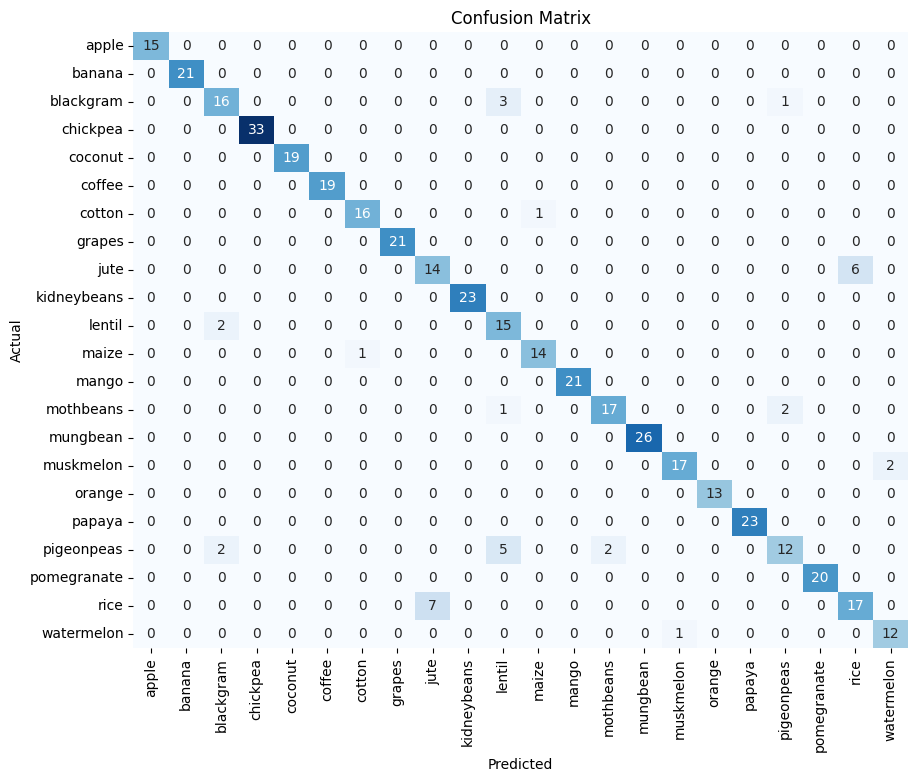

              precision    recall  f1-score   support

       apple       1.00      1.00      1.00        15
      banana       1.00      1.00      1.00        21
   blackgram       0.80      0.80      0.80        20
    chickpea       1.00      1.00      1.00        33
     coconut       1.00      1.00      1.00        19
      coffee       1.00      1.00      1.00        19
      cotton       0.94      0.94      0.94        17
      grapes       1.00      1.00      1.00        21
        jute       0.67      0.70      0.68        20
 kidneybeans       1.00      1.00      1.00        23
      lentil       0.62      0.88      0.73        17
       maize       0.93      0.93      0.93        15
       mango       1.00      1.00      1.00        21
   mothbeans       0.89      0.85      0.87        20
    mungbean       1.00      1.00      1.00        26
   muskmelon       0.94      0.89      0.92        19
      orange       1.00      1.00      1.00        13
      papaya       1.00    

In [19]:
evaluate(logistic_regression)

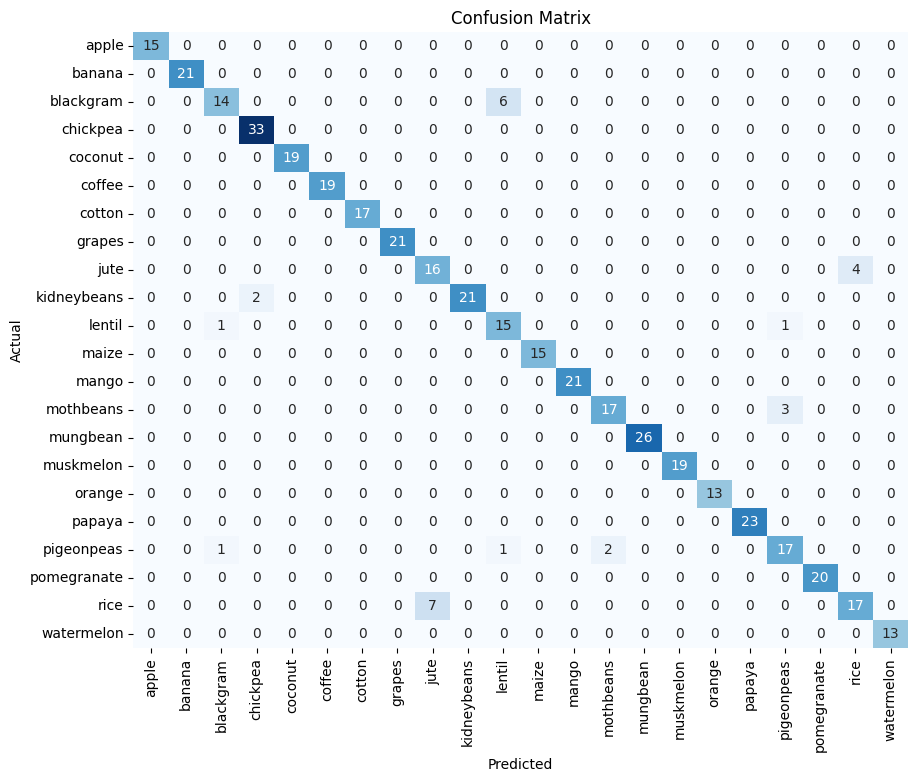

              precision    recall  f1-score   support

       apple       1.00      1.00      1.00        15
      banana       1.00      1.00      1.00        21
   blackgram       0.88      0.70      0.78        20
    chickpea       0.94      1.00      0.97        33
     coconut       1.00      1.00      1.00        19
      coffee       1.00      1.00      1.00        19
      cotton       1.00      1.00      1.00        17
      grapes       1.00      1.00      1.00        21
        jute       0.70      0.80      0.74        20
 kidneybeans       1.00      0.91      0.95        23
      lentil       0.68      0.88      0.77        17
       maize       1.00      1.00      1.00        15
       mango       1.00      1.00      1.00        21
   mothbeans       0.89      0.85      0.87        20
    mungbean       1.00      1.00      1.00        26
   muskmelon       1.00      1.00      1.00        19
      orange       1.00      1.00      1.00        13
      papaya       1.00    

In [20]:
evaluate(decision_tree)

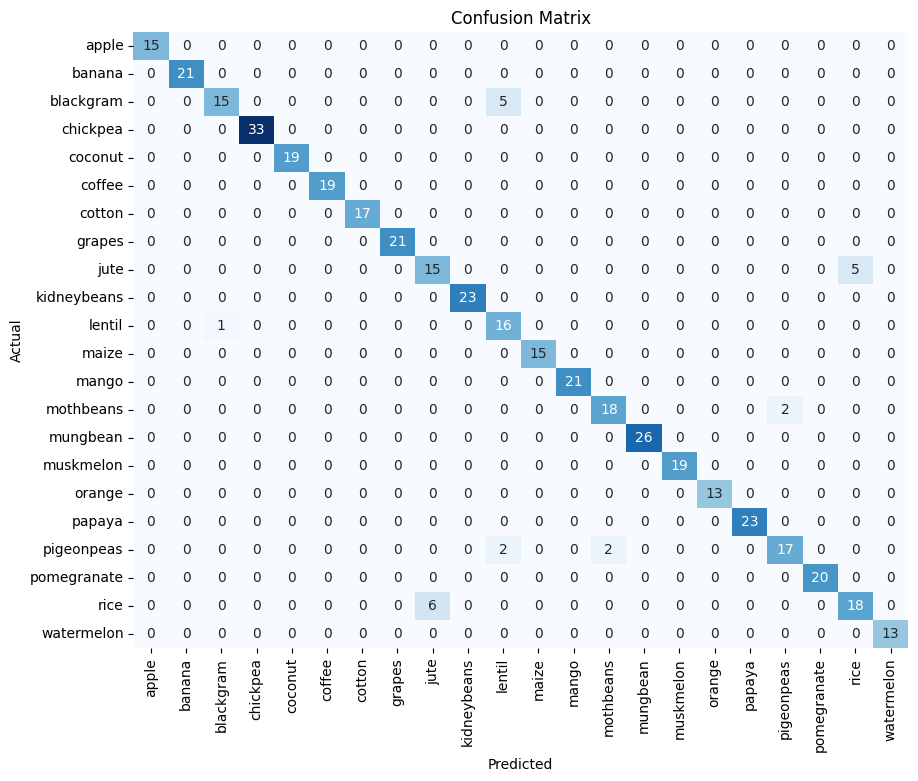

              precision    recall  f1-score   support

       apple       1.00      1.00      1.00        15
      banana       1.00      1.00      1.00        21
   blackgram       0.94      0.75      0.83        20
    chickpea       1.00      1.00      1.00        33
     coconut       1.00      1.00      1.00        19
      coffee       1.00      1.00      1.00        19
      cotton       1.00      1.00      1.00        17
      grapes       1.00      1.00      1.00        21
        jute       0.71      0.75      0.73        20
 kidneybeans       1.00      1.00      1.00        23
      lentil       0.70      0.94      0.80        17
       maize       1.00      1.00      1.00        15
       mango       1.00      1.00      1.00        21
   mothbeans       0.90      0.90      0.90        20
    mungbean       1.00      1.00      1.00        26
   muskmelon       1.00      1.00      1.00        19
      orange       1.00      1.00      1.00        13
      papaya       1.00    

In [21]:
evaluate(random_forest)

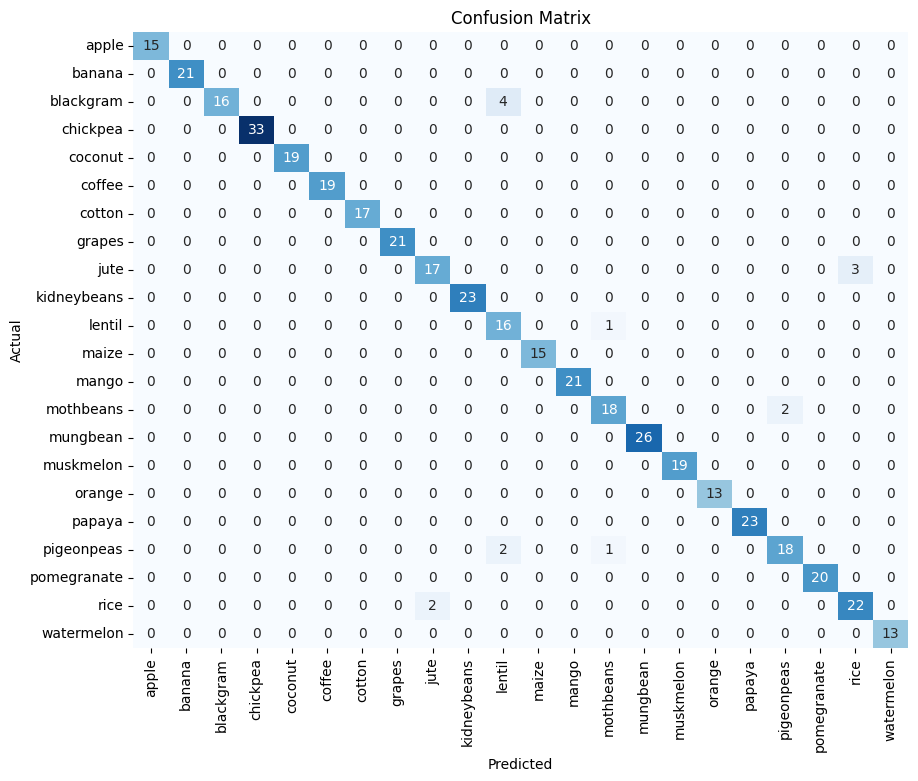

              precision    recall  f1-score   support

       apple       1.00      1.00      1.00        15
      banana       1.00      1.00      1.00        21
   blackgram       1.00      0.80      0.89        20
    chickpea       1.00      1.00      1.00        33
     coconut       1.00      1.00      1.00        19
      coffee       1.00      1.00      1.00        19
      cotton       1.00      1.00      1.00        17
      grapes       1.00      1.00      1.00        21
        jute       0.89      0.85      0.87        20
 kidneybeans       1.00      1.00      1.00        23
      lentil       0.73      0.94      0.82        17
       maize       1.00      1.00      1.00        15
       mango       1.00      1.00      1.00        21
   mothbeans       0.90      0.90      0.90        20
    mungbean       1.00      1.00      1.00        26
   muskmelon       1.00      1.00      1.00        19
      orange       1.00      1.00      1.00        13
      papaya       1.00    

In [22]:
evaluate(light_gbm)

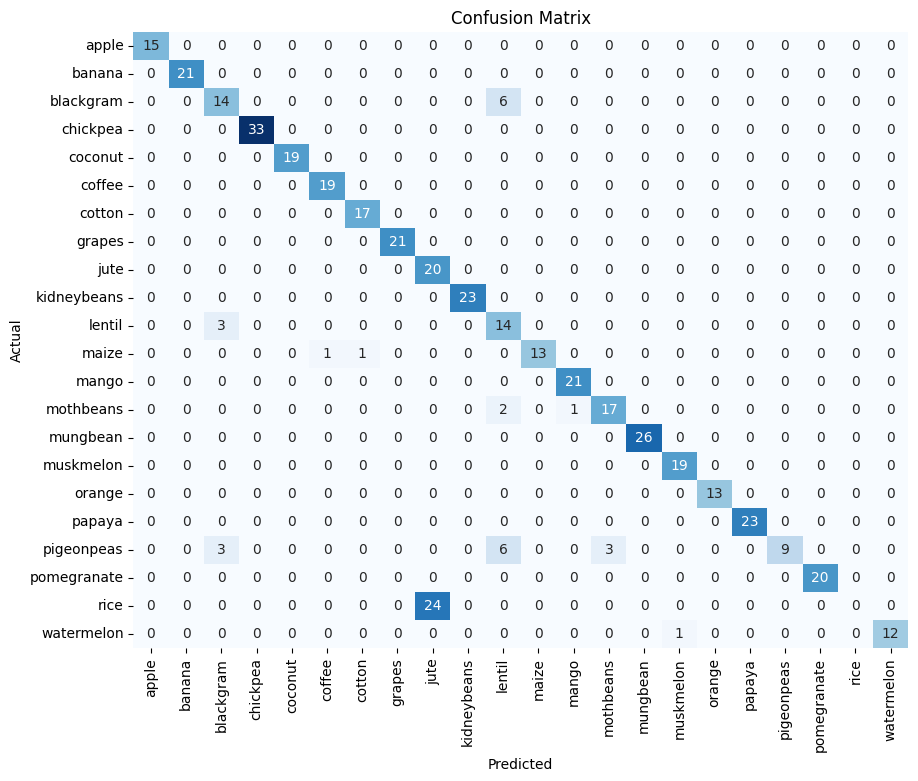

              precision    recall  f1-score   support

       apple       1.00      1.00      1.00        15
      banana       1.00      1.00      1.00        21
   blackgram       0.70      0.70      0.70        20
    chickpea       1.00      1.00      1.00        33
     coconut       1.00      1.00      1.00        19
      coffee       0.95      1.00      0.97        19
      cotton       0.94      1.00      0.97        17
      grapes       1.00      1.00      1.00        21
        jute       0.45      1.00      0.62        20
 kidneybeans       1.00      1.00      1.00        23
      lentil       0.50      0.82      0.62        17
       maize       1.00      0.87      0.93        15
       mango       0.95      1.00      0.98        21
   mothbeans       0.85      0.85      0.85        20
    mungbean       1.00      1.00      1.00        26
   muskmelon       0.95      1.00      0.97        19
      orange       1.00      1.00      1.00        13
      papaya       1.00    

In [23]:
evaluate(svc)

In [24]:
%%capture
# List of classifiers
classifiers = [
    logistic_regression,
    decision_tree,
    random_forest,
    light_gbm,
    svc
]

# Initialize an empty list to store DataFrames
dfs = []

# Loop through classifiers
for classifier in classifiers:
    # Calculate metrics for the current classifier
    metrics_result = evaluate(classifier, return_=True, conf_matrix=False)

    # Create a DataFrame from the dictionary
    metrics_df = pd.DataFrame([metrics_result])

    # Append the DataFrame to the list
    dfs.append(metrics_df)

# Concatenate DataFrames into a single DataFrame
results_df = pd.concat(dfs, ignore_index=True)

# Format the metrics to 4 decimal places in the DataFrame
results_df["accuracy"] = results_df["accuracy"].map("{:.4f}".format)
results_df["precision"] = results_df["precision"].map("{:.4f}".format)
results_df["recall"] = results_df["recall"].map("{:.4f}".format)
results_df["f1"] = results_df["f1"].map("{:.4f}".format)

In [25]:
results_df

Model accuracy precision  recall      f1
0      LogisticRegression   0.9182    0.9215  0.9182  0.9180
1  DecisionTreeClassifier   0.9364    0.9396  0.9364  0.9365
2  RandomForestClassifier   0.9477    0.9510  0.9477  0.9480
3          LGBMClassifier   0.9659    0.9688  0.9659  0.9663
4                     SVC   0.8841    0.8723  0.8841  0.8662

# Comparison of Models' Performance Metrics


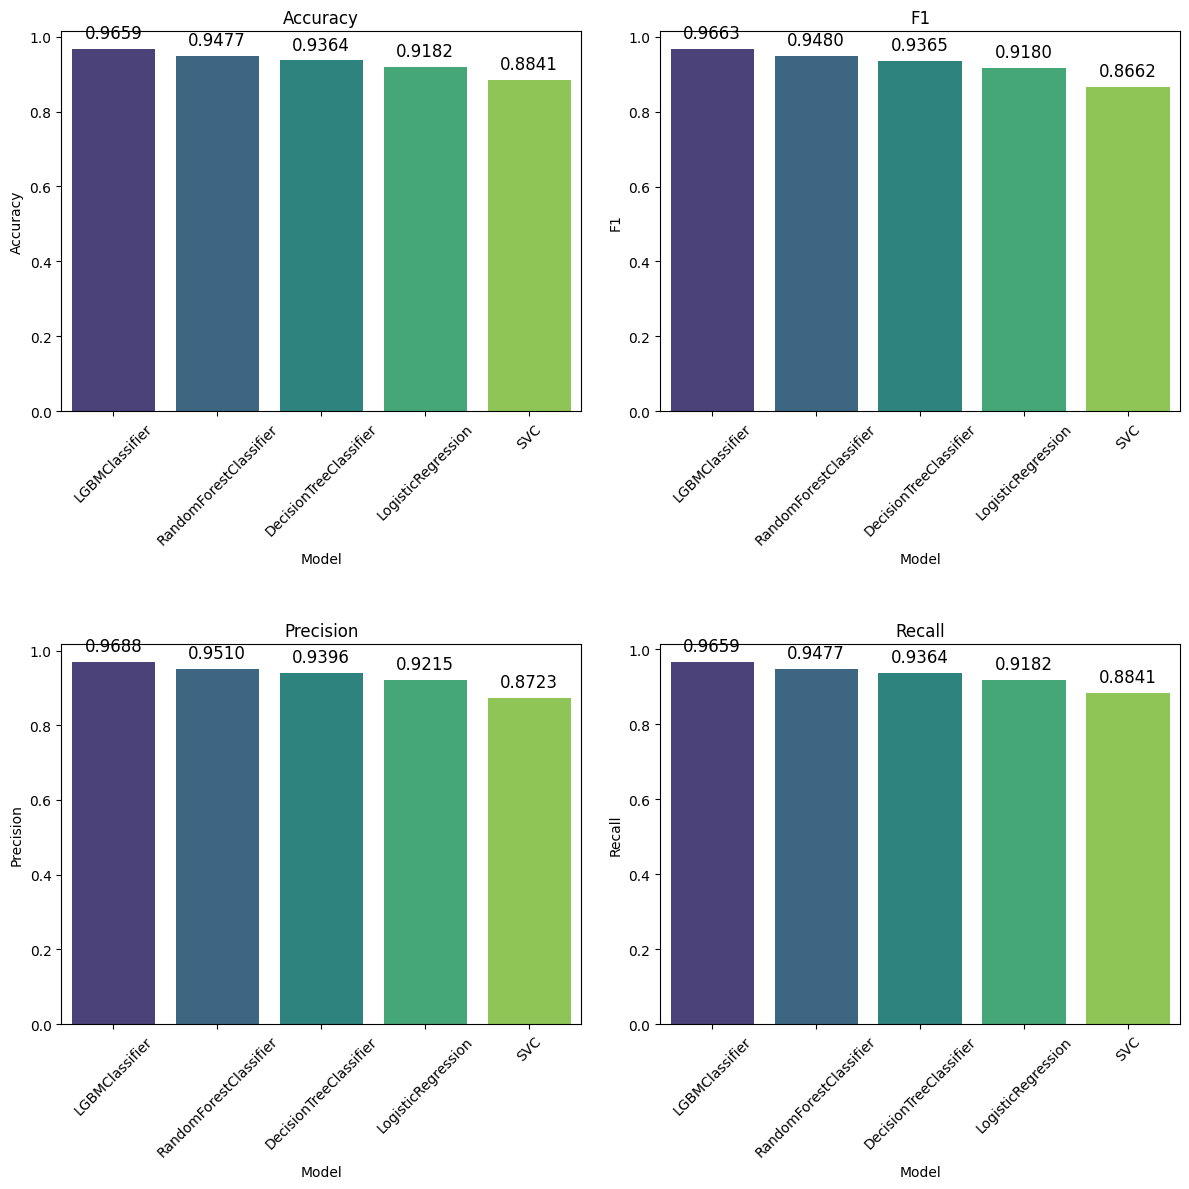

In [26]:

results_df["accuracy"] = results_df["accuracy"].astype(float)
results_df["precision"] = results_df["precision"].astype(float)
results_df["recall"] = results_df["recall"].astype(float)
results_df["f1"] = results_df["f1"].astype(float)

# Define the metrics to plot
metrics_to_plot = [
    "accuracy",
    "f1",
    "precision",
    "recall",
]

# Plotting
plt.figure(figsize=(12, 12))  # Adjust figure size for vertical layout

# Loop through each metric and create a subplot
for i, metric in enumerate(metrics_to_plot, 1):
    # Sort the DataFrame for the current metric
    sorted_df = results_df.sort_values(by=metric, ascending=False)

    plt.subplot(2, 2, i)
    ax = sns.barplot(x="Model", y=metric, data=sorted_df, palette="viridis")  # Swap x and y

    # Add the metric values on top of the bars
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.4f}',  # Use height instead of width
                    (p.get_x() + p.get_width() / 2, p.get_height()),
                    ha='center', va='bottom',  # Adjust alignment for vertical bars
                    xytext=(0, 5), textcoords='offset points', fontsize=12)
    plt.xticks(rotation=45)

    plt.title(metric.capitalize())
    plt.xlabel("Model")
    plt.ylabel(metric.capitalize())

# Adjust the layout for better visualization
plt.tight_layout(w_pad=2, h_pad=4)
plt.show()

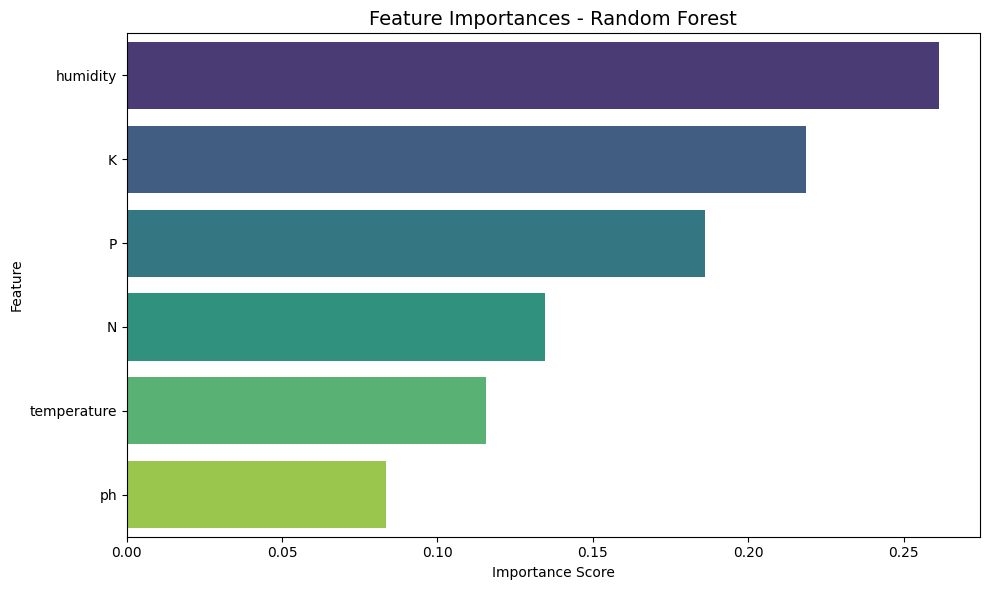

In [27]:
# Get feature importances
importances = random_forest.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by="Importance", ascending=False)

# Plot using seaborn with viridis palette
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance_df, x="Importance", y="Feature", palette="viridis")
plt.title("Feature Importances - Random Forest", fontsize=14)
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


# Make a Single Prediction Using Trained Models


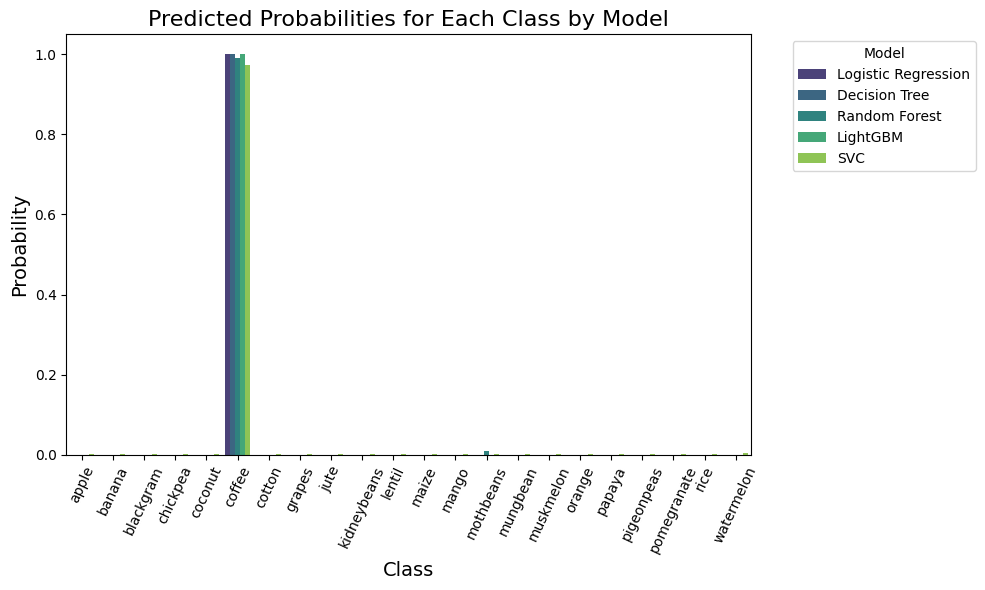


Recommended crop is: coffee


In [28]:
features = [99, 15, 27, 27.42, 56.64, 6.09]

# Predict probabilities for each class
lr_probs = logistic_regression.predict_proba([features])[0]
dt_probs = decision_tree.predict_proba([features])[0]
rf_probs = random_forest.predict_proba([features])[0]
lgbm_probs = light_gbm.predict_proba([features])[0]
svc_probs = svc.predict_proba([features])[0]

# Create a DataFrame to store the probabilities
probs_df = pd.DataFrame({
    'Class': class_names,
    'Logistic Regression': lr_probs,
    'Decision Tree': dt_probs,
    'Random Forest': rf_probs,
    'LightGBM': lgbm_probs,
    'SVC': svc_probs
})

# Melt the DataFrame for Seaborn
probs_df_melted = probs_df.melt(id_vars='Class', var_name='Model', value_name='Probability')

# Plot using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='Class', y='Probability', hue='Model', data=probs_df_melted, palette='viridis')
plt.title('Predicted Probabilities for Each Class by Model', fontsize=16)
plt.xlabel('Class', fontsize=14)
plt.ylabel('Probability', fontsize=14)
plt.xticks(rotation=65)  # Rotate class names for better readability
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

predicted_class = class_names[np.argmax(rf_probs)]
print(f"\nRecommended crop is: {predicted_class}")

# save the best model using pickle

In [29]:
import pickle
with open('model.pkl', 'wb') as f:
    pickle.dump(random_forest, f)